<a href="https://colab.research.google.com/github/tsilva/aiml-notebooks/blob/main/Backprop_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backprop from Scratch

## Introduction

This notebook is an attempt at reproing [Andrej Karpathy's](https://en.wikipedia.org/wiki/Andrej_Karpathy) implementation of [karpathy/micrograd](https://github.com/karpathy/micrograd) by following his excellent lesson [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0), where he teaches how to:

- Create a simple engine that tracks the calculations in a [neural network](https://en.wikipedia.org/wiki/Neural_network_(machine_learning);
- Feed inputs through the network to get its predictions;
- Check how far off the predictions are from the actual results ([loss calculation](https://en.wikipedia.org/wiki/Loss_function));
- Figure out how much each part of the calculation contributed to the final result ([gradient](https://en.wikipedia.org/wiki/Gradient) calculation using [backpropagation](https://en.wikipedia.org/wiki/Backpropagation));
- Adjust the network's settings to make its predictions more accurate (improving with [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)).

The purpose of this notebook is for my own self-learning, and shouldn't add much to the original lesson beyond extra verbosity.

## Understanding Derivatives

Derivatives are crucial for building and training neural networks. A derivative measures the rate at which a function changes with respect to its input, indicating the function's sensitivity to small changes in that input.

Imagine walking through a complex landscape with hills and valleys. The slope of the ground at any point represents the derivative:
- When going downhill, the slope (derivative) is negative, indicating that the altitude decreases as you move forward.
- At the valley floor, the slope is zero, suggesting a critical point where the elevation doesn't change (this could be a minimum, maximum, or a flat region).
- As you climb uphill, the slope is positive, showing that the altitude increases as you proceed.

In neural networks, the landscape represents the error surface, and the goal is to find the lowest point, corresponding to the minimum error. Derivatives guide the adjustment of model parameters to move toward this minimum:
- A negative derivative suggests that increasing the parameter might reduce the error.
- A positive derivative suggests that decreasing the parameter might reduce the error.
- A zero derivative indicates a critical point, requiring further analysis to determine whether it's a minimum, maximum, or saddle point.

Let's define a mathematical function representing "a valley" and analyze its derivatives:

In [1]:
def f(x):
    return 3*x**2 - 4*x + 5

f(3)

20

Now let's plot that function, and mark two points on it, in this case $f(-2)$ and  $f(-2/3)$:

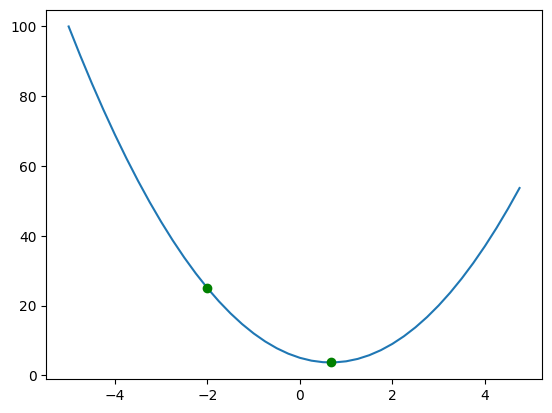

In [2]:
import numpy as np
import matplotlib.pyplot as plt

xx = np.arange(-5, 5, 0.25) # Create a range for x, between -5 and 5, split in increments of 0.25.
yy = f(xx) # Get the y values for that range
plt.plot(xx, yy) # Plot the function

plt.plot(-2, f(-2), 'go') # Point with descending slope (negative)
plt.plot(2/3, f(2/3), 'go') # Point where slope is horizontal (zero)

To estimate the derivative of $f(x)$ at $x=-2$ we can use the [forward difference method](https://en.wikipedia.org/wiki/Finite_difference):

$\frac{f(x + h) - f(x)}{h}$

This formula approximates the slope of a by measuring the change in the function's value for a small increment $h$.

Let's estimate the derivative of $f(-2)$:

In [3]:
h = 0.0000001
x = -2
f(x), f(x+h), f(x+h)-f(x), (f(x+h)-f(x))/h, round((f(x+h)-f(x))/h)

(25, 24.99999840000003, -1.5999999689597644e-06, -15.999999689597644, -16)

Notice how the slope is negative, as expected, since that point is situated in a descending slope.

Now let's calculate it for $x = 2/3$:

In [4]:
h = 0.0000001
x = 2/3
f(x), f(x+h), f(x+h)-f(x), (f(x+h)-f(x))/h, round((f(x+h)-f(x))/h)

(3.666666666666667,
 3.6666666666666967,
 2.9753977059954195e-14,
 2.9753977059954195e-07,
 0)

The derivative is $0$, as expected, since the slope at that point is horizontal.

It would now be good to be able to visualize the derivative, so we need to determine the equation that represents it. Let's solve for that:

- $f(x) = 3x^2 - 4x + 5$ (the function we plotted)
- $f(x + h) - f(x) / h$ (the forward difference method formula)
- $(3(x + h)^2 - 4(x + h) + 5) - (3x^2 - 4x + 5)$
- $(3(x^2 + 2xh + h^2) - 4x - 4h + 5) - (3x^2 - 4x + 5)$
- $(3x^2 + 6xh + 3h^2 - 4x - 4h + 5) - (3x^2 - 4x + 5)$
- $3x^2 + 6xh + 3h^2 - 4x - 4h + 5 - 3x^2 + 4x - 5$
- $6xh + 3h^2 - 4h$
- $6x + 3h - 4$
- $6x + 3 \times 0 - 4$ ($h$ is the smallest number possible that is close to $0$)
- $6x - 4$

The formula $6x - 4$ gives the exact slope of the function at any point, not an approximation like we did before. Let's use this exact derivative to double-check the values we approximated previously for $x = -2$ and $x = 2/3$:

In [5]:
def derivative_f(x):
    return 6 * x - 4

derivative_f(-2), derivative_f(2/3)

(-16, 0.0)

We got pretty much the same values as we did when we calculated them before, so the derivative equation is correct.

Let's use it to plot a line that is tangent to those points and has a slope matching their the respective derivatives at those points:

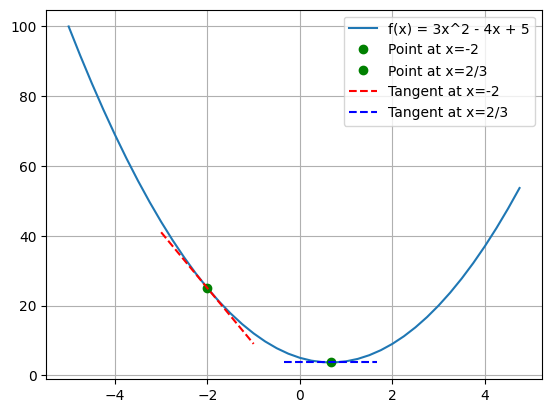

In [6]:
# Create a range for x, between -5 and 5, split in increments of 0.25
xx = np.arange(-5, 5, 0.25)
yy = f(xx)

# Plot the function
plt.plot(xx, yy, label='f(x) = 3x^2 - 4x + 5')

# Plot our points of interest
x1, x2 = -2, 2/3
y1, y2 = f(x1), f(x2)
plt.plot(x1, y1, 'go', label='Point at x=-2')
plt.plot(x2, y2, 'go', label='Point at x=2/3')

# Tangent line at x1
dy1 = derivative_f(x1)
tangent_x1 = np.linspace(x1-1, x1+1, 100)
tangent_y1 = y1 + dy1 * (tangent_x1 - x1)
plt.plot(tangent_x1, tangent_y1, 'r--', label='Tangent at x=-2')

# Tangent line at x2
dy2 = derivative_f(x2)
tangent_x2 = np.linspace(x2-1, x2+1, 100)
tangent_y2 = y2 + dy2 * (tangent_x2 - x2)
plt.plot(tangent_x2, tangent_y2, 'b--', label='Tangent at x=2/3')

plt.legend()
plt.grid(True)

## Building the Calculation Graph

When training a model, we need to minimize error by adjusting its parameters. To achieve this, we calculate the partial derivatives of the error with respect to each parameter. This requires tracking each step of the calculation and understanding the dependencies between them.

One effective way to manage this is by creating a wrapper class which encapsulates scalar values and leverages operator overloading. This allows us to automatically build a dependency graph that represents the entire calculation.

Let's implement our wrapper `Node` class:



In [7]:
class Node:
    def __init__(self, data, children=(), op=None):
        self.data = data # The value of the variable
        self.children = set(children) # The nodes that produced this node's value after having an operation applied to them (eg: c = a + b)
        self.op = op # The operation applied on the children to produce this node
        self.label = None # The name of the node

    def __add__(self, other):
        # Return a new node instance that has the result of the op,
        # and tracks which nodes created it and with which op
        return Node(self.data + other.data, (self, other), op='+')

    def __repr__(self):
        label = f"{self.label} = " if self.label else ""
        children = f"; {self.op.join(child.label or str(child.data) for child in self.children)}" if self.children and any(child.label for child in self.children) else ""
        return f"Node({label}{self.data}{children})"

a = Node(5); a.label = "a"
b = Node(10); b.label = "b"
c = a + b; c.label = "c"
c

Node(c = 15; b+a)

Won't work for this though:

In [8]:
try: Node(5) + 5
except Exception as e: print(e)

'int' object has no attribute 'data'


`other` is an `int`, not a `Node`, that's why that didn't work.

Let's patch our `__add__` to cast the other value if necessary:

In [9]:
def __add__(self, other):
    other = other if isinstance(other, Node) else Node(other)
    return Node(self.data + other.data, (self, other), op='+')
Node.__add__ = __add__

Node(5) + 5

Node(10)

Works now! Won't work for this though:

In [10]:
try: 5 + Node(5)
except Exception as e: print(e)

unsupported operand type(s) for +: 'int' and 'Node'


Still solvable because Python will check both sides of the operator for an object with a function that can solve it:

In [11]:
def __radd__(self, other):
    return self + other # this was called with other + self, so by reversing the order we'll make the __add__ operator be called
Node.__radd__ = __radd__

5 + Node(5), Node(5) + 5

(Node(10), Node(10))

Let's add support for *multiplication* (pretty much the same pattern as overriding *addition*):

In [12]:
def __mul__(self, other):
    other = other if isinstance(other, Node) else Node(other)
    return Node(self.data * other.data, (self, other), op='*')
Node.__mul__ = __mul__

def __rmul__(self, other):
    return self * other
Node.__rmul__ = __rmul__

Node(10) * 2, 2 * Node(10)

(Node(20), Node(20))

Now we'll implement negation using *multiplication*, and then use that to implement *subtraction* by combining it with *addition*:

In [13]:
def __neg__(self):
   return self * -1 # implementing negation allows us to re-use the __add__ operator overload
Node.__neg__ = __neg__

def __sub__(self, other):
    return self + (-other) # re-uses __add__ operator overload
Node.__sub__ = __sub__

def __rsub__(self, other):
    return other + (-self) # re-uses __add__ operator overload
Node.__rsub__ = __rsub__

Node(10) - 2, 2 - Node(10)

(Node(8), Node(-8))

And now *exponentiation*, and then use that along with *multiplication* to implement *division* (because $\frac{a}{b} = a \times b^{-1}$):

In [14]:
def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    return Node(self.data**other, (self,), f'**{other}')
Node.__pow__ = __pow__

def __truediv__(self, other): # self / other
    other = other if isinstance(other, Node) else Node(other)
    return self * other**-1
Node.__truediv__ = __truediv__

def __rtruediv__(self, other): # other / self
    other = other if isinstance(other, Node) else Node(other)
    return other * self**-1
Node.__rtruediv__ = __rtruediv__

Node(10) / 2, 2 / Node(10)

(Node(5.0), Node(0.2))

Now that we have support for mosth arithmetic operators, let's build a calculation graph for the formula $(a \times b + c) \times f$:

In [15]:
def create_calc():
  a = Node(2.0); a.label = "a"
  b = Node(-3.0); b.label = "b"
  c = Node(10.0); c.label = "c"
  e = a * b; e.label = "e"
  d = e + c; d.label = "d"
  f = Node(-2.0); f.label = "f"
  L = d * f; L.label = "L"
  return L

L = create_calc()
L

Node(L = -8.0; f*d)

Let's write some code to be able to visualize these graphs:

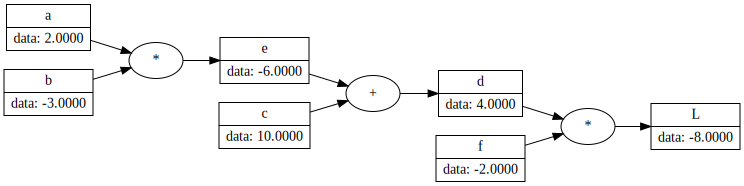

In [16]:
import graphviz

# Function to generate a label for a node in the graph. This label will include the node's label and data.
def _draw_graph__node_label(node):
    return f"{node.label}|data: {node.data:.4f}"

# Function to plot a computation graph, starting from the root node.
def draw_graph(root, format='svg', rankdir='LR'):
    # Helper function to trace through the computation graph, gathering nodes and edges.
    def _trace(root):
        nodes, edges = set(), set()  # Sets to store unique nodes and edges.

        # Recursive function to build the graph by traversing the computation nodes.
        def _build(v):
            if v not in nodes:  # If the node hasn't been added yet.
                nodes.add(v)  # Add the current node to the set of nodes.
                for child in v.children:  # Iterate through the children (dependencies) of the current node.
                    edges.add((child, v))  # Add an edge from the child to the current node.
                    _build(child)  # Recursively build the graph from the child node.

        _build(root)  # Start building the graph from the root node.
        return nodes, edges  # Return the sets of nodes and edges.

    # Ensure the graph's direction is either left-to-right ('LR') or top-to-bottom ('TB').
    assert rankdir in ['LR', 'TB']

    # Get the nodes and edges by tracing the graph starting from the root.
    nodes, edges = _trace(root)

    # Create a new Graphviz Digraph object with the specified format and rank direction.
    dot = graphviz.Digraph(format=format, graph_attr={'rankdir': rankdir})

    # Add each node to the graph.
    for n in nodes:
        node_label = _draw_graph__node_label(n)  # Generate the label for the node.
        dot.node(name=str(id(n)), label=node_label, shape='record')  # Add the node to the graph with its label.

        if n.op:  # If the node represents an operation (not a leaf node).
            dot.node(name=str(id(n)) + n.op, label=n.op)  # Add a separate node for the operation.
            dot.edge(str(id(n)) + n.op, str(id(n)))  # Connect the operation node to the main node.

    # Add edges between nodes based on the computation graph.
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)  # Draw an edge from n1 to the operation node of n2.

    return dot  # Return the final graph object for rendering.

draw_graph(L)

## Calculating Gradients with Backpropagation

The main reason we track the calculation graph is to figure out how much each part of the model we're training contributed to the final result. To do so, we need to add support to track the partial derivatives (aka gradients, we'll use these terms interchangeably) for each node in respect to the calculation result:

In [17]:
def __init__(self, data, children=(), op=None):
    self.data = data
    self.children = children
    self.op = op
    self.label = None
    self.grad = 0.0 # Gradients will be stored here
Node.__init__ = __init__

Let's also create a method `get_node()` to grab specific nodes from the calculation graph at any time (these aren't available globally since they are in the scope of the `create_calc()` function):

In [18]:
def get_node(self, labels):
  nodes_map = {}
  def _visit(node):
    for _node in node.children: _visit(_node)
    nodes_map[node.label] = node
  _visit(self)
  nodes = [nodes_map.get(label) for label in labels]
  nodes = nodes[0] if len(nodes) == 1 else nodes
  return nodes
Node.get_node = get_node

And while we're at it let's create a method `get_nodes()` that returns all nodes in the graph listed from first to last (will be useful later):

In [19]:
def _node_get_nodes(self):
  node_list, visited = [], set()
  def _dfs(v):
    if v not in visited:
      visited.add(v)
      for child in v.children:
        _dfs(child)
      node_list.append(v)
  _dfs(self)
  return node_list
Node.get_nodes = _node_get_nodes

L = create_calc()
L.get_nodes()

[Node(a = 2.0),
 Node(b = -3.0),
 Node(e = -6.0; a*b),
 Node(c = 10.0),
 Node(d = 4.0; e+c),
 Node(f = -2.0),
 Node(L = -8.0; d*f)]

Let's get our hands dirty by manually calculating the gradients for all the nodes that led up to $L$. We'll do this using the [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) algorithm, which calculates the gradients by propagating the error backward through the network, layer by layer. These gradients tell us how much each weight contributed to the error.

First we initialize the gradient of $L$ to $1.0$; because if you change $L$ by $0.000001$, well... it changes by $0.000001$, duh! 😅:

In [20]:
L = create_calc()
L.grad = 1.0
L

Node(L = -8.0; d*f)

To visualize how gradients are changing as we perform our calculations, let's add support for showing those in the graph visualizer:

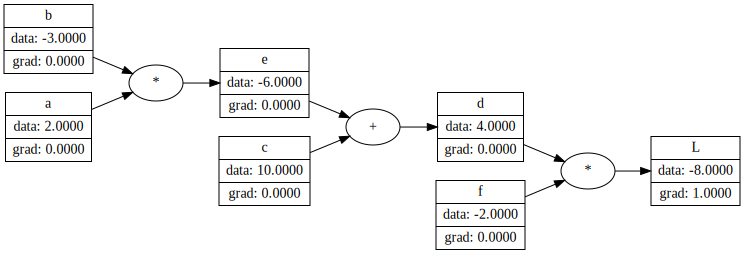

In [21]:
def _draw_graph__node_label(node): # This is an override of the labeling function we defined before
  return "|".join([x for x in [node.label, f"data: {node.data:.4f}", f"grad: {node.grad:.4f}"] if x])

draw_graph(L)

We need to calculate the partial derivative of $L$ (the result) with respect to $d$, mathematically described as $\frac{dL}{dd}$ (representing how a minor increment in $d$ changes $L$). Let's do it using the derivative approximation formula we learned above:

- $L = d * f$  (Given)

- $\frac{dL}{dd} = ?$ (Objective)

- $\frac{f(x+h) - f(x)}{h} = \frac{(d+h) * f - d * f}{h}$  (Using the forward difference method)

- $\frac{d * f + h * f - d * f}{h}$  (Expand and simplify the expression)

- $\frac{h * f}{h} = f$  (Cancel out $h$ in the numerator and denominator)

- $\frac{dL}{dd} = f$  (Final result)

The gradient of $d$ is the same as the value of $f$. This makes sense because, since this is a multiplication, changes to $d$ have an impact proportional to the value of $f$.

Let's set the gradient of $d$ to be the same as the value of $f$ then:

In [22]:
d, f = L.get_node(["d", "f"])
d.grad = f.data

It's kind of obvious now that the gradient for $f$ will be the value of $d$ for the very same reason, but let's go through the ropes:

- $L = d * f$  (Given)

- $\frac{dL}{df} = ?$ (Objective)

- $\frac{f(x+h) - f(x)}{h} = \frac{d * (f+h) - d * f}{h}$  (Using the forward difference method)

- $\frac{d * f + d * h - d * f}{h}$  (Expand and simplify the expression)

- $\frac{d * h}{h} = d$  (Cancel out $h$ in the numerator and denominator)

- $\frac{dL}{df} = d$  (Final result)

Confirmed! Let's set the gradient of $f$ to be the same as the value of $d$:

In [23]:
f = L.get_node("f")
f.grad = d.data

The first level of our backward pass is complete, let's check our status:

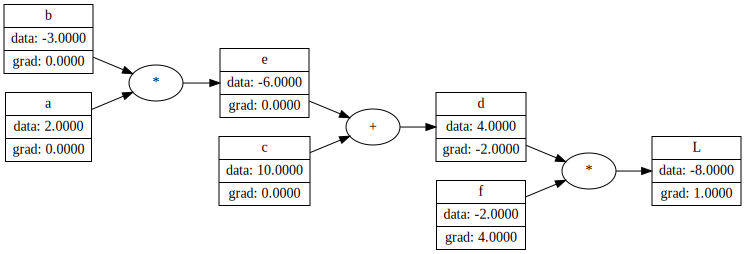

In [24]:
draw_graph(L)

Just for the sake of verbosity, let's also approximate the gradients numerically just to be sure the results match. We're going to calculate $\frac{dL}{dd}$ and $\frac{dL}{df}$, and its values should be exactly the same as the ones that ended up in the visualization above:

In [25]:
# Let's redefine our calculation factory to be more flexible,
# allowing us to adjust the node values on creation
def create_calc(ops = {}):
  def _node(label, value):
    value = ops.get(label, lambda x: x)(value)
    node = value if isinstance(value, Node) else Node(value)
    node.label = label
    return node

  a = _node("a", 2.0)
  b = _node("b", -3.0)
  c = _node("c", 10.0)
  e = _node("e", a * b)
  d = _node("d", e + c)
  f = _node("f", -2.0)
  L = _node("L", d * f)
  return L

# And now let's create a function that calculates the actual partial
# derivative value for any parameter of a calculation graph
def calc_dLd(param):
  # Calculate f(x)
  L1 = create_calc()

  # Calculate f(x + h)
  h = 0.000001
  L2 = create_calc({param : lambda x: x + h})

  # Calculate (f(x + h) - f(x)) / h
  return (L2 - L1) / h

(
  create_calc({"a" : lambda x: 10}), # Double check the method modification worked
  calc_dLd("d"), # Calculate dL/dd
  calc_dLd("f")  # Calculate dL/df
)

(Node(L = 40.0; d*f), Node(-2.000000000279556), Node(3.9999999996709334))

Double checked! Nevermind the $\frac{dL}{df} = 3.999...$, this is merely a consequence of floating number calculations not having infinite precision; the hardware returned the closest number it can represent.

Moving on to the next step, let's now calculate the gradient for $e$ with respect to $L$, aka $\frac{dL}{de}$.

This is where the [**chain rule**](https://en.wikipedia.org/wiki/Chain_rule) comes in, a key concept in backpropagation. The chain rule allows us to propagate gradients backward through the network, enabling the calculation of derivatives of the loss function with respect to each parameter. It tells us that $\frac{dL}{de} = \frac{de}{dd} \times \frac{dL}{dd}$, meaning that we can calculate the derivatives in respect to the result for a certain parameter as long as we calculated the one that came immediately before it.

With that knowledge in hand, let's calculate the local derivative $\frac{de}{dd}$ first:

- $d = e + c$ (Given)

- $\frac{dd}{de} = ?$ (Objective)

- $\frac{f(x + h) - f(x)}{h} = \frac{(e + h + c) - (e + c)}{h}$ (Using the forward difference method)

- $\frac{e + h + c - e - c}{h}$ (Expand and simplify the expression)

- $\frac{h}{h} = 1$ (Cancel out $h$ in the numerator and denominator)

- $\frac{dd}{de} = 1$ (Final result)

And now we can calculate $\frac{dL}{de}$ using the **chain rule**:

- $\frac{dd}{de} = 1$ (Given)

- $\frac{dL}{dd} = -2$ (Given)

- $\frac{dL}{de} = \frac{dd}{de} \times \frac{dL}{dd}$ (Chain rule)

- $\frac{dL}{de} = 1 \times -2 = -2$ (Final solution)

This means that the gradient from the node that results from the *addition* computation was propagated to this node, this is because the local derivative of a variable in an *addition* operation is always *1*. For this reason, whenever you find an *addition* operation, gradients are copied from the result to the operation's terms.

Let's set the gradients of $e$ and $c$ to be the same as the gradient of $d$:

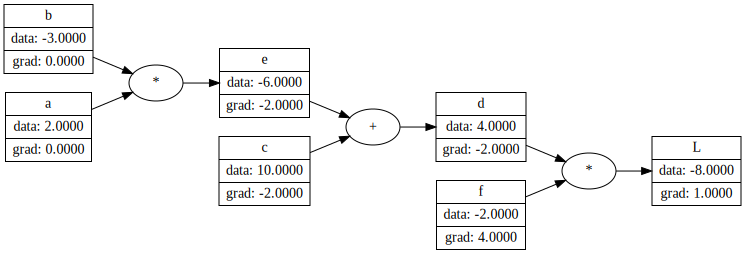

In [26]:
c,e,d = L.get_node(["c", "e", "d"])
e.grad = d.grad
c.grad = d.grad

draw_graph(L)

Time for a double check:

In [27]:
calc_dLd("e"), calc_dLd("c")

(Node(-2.000000000279556), Node(-1.999999998503199))

Double checked, we got the same values as in the graph visualization above (again, nevermind the precision errors).

And now we're almost there, just need to calculate $\frac{dL}{da}$ and $\frac{dL}{db}$.
You know the drill, we can do it because we already know $\frac{dL}{de}$.

**Chain rule** time, first let's calculate $\frac{dL}{da}$:

- $e = a \times b$ (Given)

- $\frac{de}{da} = \frac{e(a + h, b) - e(a, b)}{h}$ (Using the definition of the derivative)

- $\frac{de}{da} = \frac{((a + h) * b) - (a \times b)}{h}$ (Substitute $e = a \times b$)

- $\frac{de}{da} = \frac{a \times b + h \times b - a * b}{h}$ (Expand and simplify the expression)

- $\frac{de}{da} = \frac{h \times b}{h}$ (Simplify further)

- $\frac{de}{da} = b$ (Local derivative result)

- $\frac{dL}{da} = \frac{de}{da} \times \frac{dL}{de}$ (Chain rule)

- $\frac{dL}{da} = b \times \frac{dL}{de}$ (Final result)

And now for $\frac{dL}{db}$:

- $\frac{de}{db} = \frac{e(a, b + h) - e(a, b)}{h}$ (Using the definition of the derivative)

- $\frac{de}{db} = \frac{a \times (b + h) - a \times b}{h}$ (Substitute $e = a \times b$)

- $\frac{de}{db} = \frac{a \times b + a \times h - a \times b}{h}$ (Expand and simplify the expression)

- $\frac{de}{db} = \frac{a \times h}{h}$ (Simplify further)

- $\frac{de}{db} = a$ (Local derivative result)

- $\frac{dL}{db} = \frac{de}{db} \times \frac{dL}{de}$ (Chain rule)

- $\frac{dL}{db} = a \times \frac{dL}{de}$ (Final result)

Let's apply the results to the nodes:

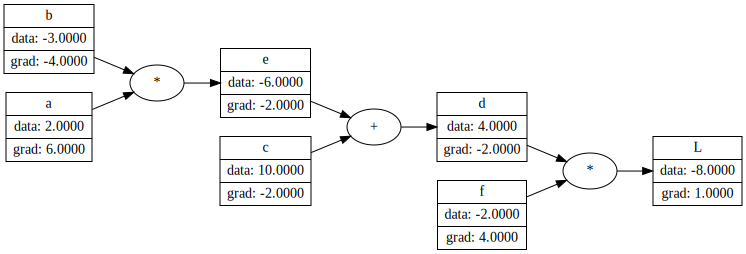

In [28]:
a, b, e = L.get_node(["a", "b", "e"])
a.grad = b.data * e.grad
b.grad = a.data * e.grad
draw_graph(L)

Final double check:

In [29]:
calc_dLd("a"), calc_dLd("b")

(Node(6.000000000838668), Node(-4.000000000559112))

Success! We have completed a full round of backpropagation, manually calculated step by step!

## Performing Gradient Descent

[Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) is the main optimization algorithm used in neural networks to use the gradient information to iteratively adjust its parameters in order to minimize the loss function and improve prediction accuracy.

To perform gradient descent, we adjust the model's parameters by subtracting the gradients multiplied by a factor called the [learning rate](https://en.wikipedia.org/wiki/Learning_rate). The gradient shows the direction of steepest ascent, and by moving in the opposite direction, we aim to reduce the loss. The learning rate controls the step size: a smaller rate means finer, more gradual adjustments, while a larger rate speeds up convergence but risks overshooting. The objective is to fine-tune parameters to minimize the loss effectively.

Let's update the parameter values using the gradients from our previous calculations:

In [30]:
a, b, c, d, e, f = L.get_node(["a", "b", "c", "d", "e", "f"])
learning_rate = 0.01
L = create_calc({
  "a" : lambda x: a.data - learning_rate * a.grad,
  "b" : lambda x: b.data - learning_rate * b.grad,
  "c" : lambda x: c.data - learning_rate * c.grad,
  "d" : lambda x: d.data - learning_rate * d.grad,
  "e" : lambda x: e.data - learning_rate * e.grad,
  "f" : lambda x: f.data - learning_rate * f.grad
})
L

Node(L = -8.2008; d*f)

Notice how *L* is now $-8.2008$ instead of $-8.0$. It's a smaller number, as expected, meaning we were able to adjust the variables of our calculation to produce a result that is smaller than the previous one.

This is all we need to be able to train a neural network; when the result of the calculation is the loss, we need only to:
- Keep showing inputs to the network by setting them as the values of the variables at the start of calculation graph (eg: $a$ and $b$);
- Propagate them through the graph all the way to the end (forward pass);
- Calculate the loss function (more on this later, this will be the final node of the calculation graph);
- Backpropagate to find the gradients for each parameter;
- Do a gradient descent step to adjust the parameters;
- Rinse and repeat until we achieve the desired loss.


## Automating Backpropagation

Let's now implement the backpropagation step so that we don't have to manually calculate gradients anymore.

First we need to make sure that all nodes that result from an *addition* operation know how to backpropagate their gradients. Remember, in an *addition* operation, the gradients for the input nodes are the same as the gradient of the result:

In [31]:
def __add__(self, other):
    other = other if isinstance(other, Node) else Node(other)
    out = Node(self.data + other.data, (self, other), "+")

    def _backward():
        self.grad += out.grad # set the gradient of the result in the left term of the operation
        other.grad += out.grad  # set the gradient of the result in the right term of the operation
    out._backward = _backward

    return out
Node.__add__ = __add__

And now for the *multiplication*, the gradient is proportional to the other term's value:

In [32]:
def __mul__(self, other):
    other = other if isinstance(other, Node) else Node(other)
    out = Node(self.data * other.data, (self, other), "*")

    def _backward():
        # The local derivative of the multiplication in respect to one of its terms
        # is the same as the data of the other term (eg: self.grad = other.data),
        # multiplying by `out.grad` we are using the chain rule to calculate
        # the partial derivative of term in respect to the graph's result value (eg: loss)
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = _backward

    return out
Node.__mul__ = __mul__

And finally for *exponentiation*:

In [33]:
def __pow__(self, other):
    assert isinstance(other, (int, float)), "second term must be int or float"
    x = self.data
    out = Node(x**other, (self,), f'**{other}')

    def _backward():
        # The local derivative of the power function (x^n) with respect to x is (n * x^(n-1)).
        # Therefore, to compute the gradient of x with respect to the final output (out),
        # we multiply the local derivative by `out.grad` using the chain rule.
        self.grad += (other * x**(other-1)) * out.grad
    out._backward = _backward

    return out
Node.__pow__ = __pow__

We can finally make nodes have a `backward()` method that calculates the gradient from the last node all the way back to the inputs by using the **chain rule**:

In [34]:
def backward(self):
    self.grad = 1.0
    nodes = self.get_nodes()
    for node in reversed(nodes): # Backpropagate from the end result node to the input nodes
      if not hasattr(node, "_backward"): continue
      node._backward()
Node.backward = backward

We'll now perform backpropagation using `backward()`, and then do manual gradient descent using the calculated gradients:

In [35]:
L = create_calc() # perform the calculation
L.backward() # do backpropagation
a, b, c, d, e, f = L.get_node(["a", "b", "c", "d", "e", "f"]) # fetch the nodes to get the gradients

# apply the gradients to the current values
learning_rate = 0.01
L = create_calc({
  "a" : lambda x: a.data - learning_rate * a.grad,
  "b" : lambda x: b.data - learning_rate * b.grad,
  "c" : lambda x: c.data - learning_rate * c.grad,
  "d" : lambda x: d.data - learning_rate * d.grad,
  "e" : lambda x: e.data - learning_rate * e.grad,
  "f" : lambda x: f.data - learning_rate * f.grad
})
L

Node(L = -8.2008; d*f)

We got $L = -8.2008$ which is exactly the same result we got when we performed the this pass manually before, meaning that our `backward()` method seems to be working.

## Building a Neural Network

Neural networks have layers of connected neurons that process data from input to output. Each neuron takes in inputs, multiplies them by weights, sums them up, and then applies a non-linear activation function to produce an output (this combination of linear and non-linear operations is what allows neural networks to model complex functions).

A crucial part of designing a neural network is choosing the right activation function. Here, we'll use the `tanh` function, let's plot it to visualize how it behaves:

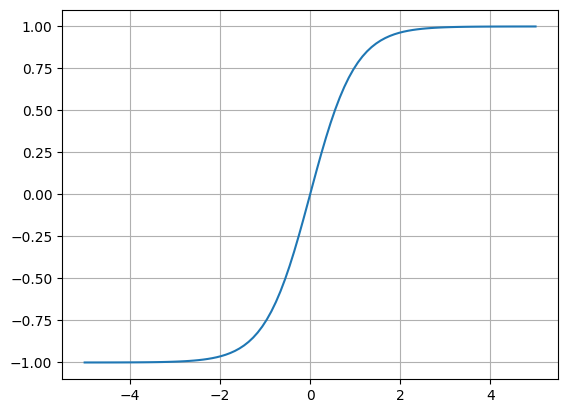

In [36]:
xx = np.linspace(-5, 5, 100) # create a list of 100 points from -5 to 5
yy = np.tanh(xx) # get the y values for each of the x values we generated before
plt.plot(xx, yy) # plot the tanh function
plt.grid(True) # enable plot grid

The `tanh` function is well-suited for neural networks because it is zero-centered, meaning it outputs values symmetrically between `[-1, 1]`. This non-linearity enables the network to learn complex patterns, while the zero-centered output helps stabilize and speed up training by preventing extreme values.

Let's add `tanh` our `Node` class:

In [37]:
import math

def tanh(self):
    # Calculate the tanh value and create
    # the node representing the operation
    x = self.data
    tanh = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
    out = Node(tanh, (self,), 'tanh')

    def _backward():
        # The derivative of tanh(x) in respect to x is (1 - tanh(x)^2),
        # multiplying by `out.grad` we are using the chain rule to calculate
        # the derivative of tanh(x) in respect to the graph's result value (eg: loss)
        self.grad += (1 - tanh ** 2) * out.grad
    out._backward = _backward

    return out
Node.tanh = tanh

Let's create a calculation graph resembling a neural network. We'll define *inputs*, *weights*, and *biases*, then perform the following steps:

1. Multiply the *inputs* by the *weights*.
2. Sum the results.
3. Add the *bias*.
4. Pass the output through the $tanh$ function to squash the activation into a standard range.

This process simulates the flow from input to activation in a single neuron. Here's the code:

In [38]:
# inputs
x1 = Node(2.0); x1.label = "x1";
x2 = Node(0.0); x2.label = "x2";

# weights
w1 = Node(-3.0); w1.label = "w1";
w2 = Node(1.0); w2.label = "w2";

# bias
b = Node(6.8813735870195432); b.label = "b";

# propagate inputs through neuron
x1w1 = x1 * w1; x1w1.label = "x1w1";
x2w2 = x2 * w2; x2w2.label = "x2w2";
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2";
n = x1w1x2w2 + b; n.label = "n"; # add bias
o = n.tanh(); o.label = "o"; # run activation function
o

Node(o = 0.7071067811865476; n)

Now let's backpropagate the result and plot the graph to see the structure and how the resulting gradients were successfully calculated:

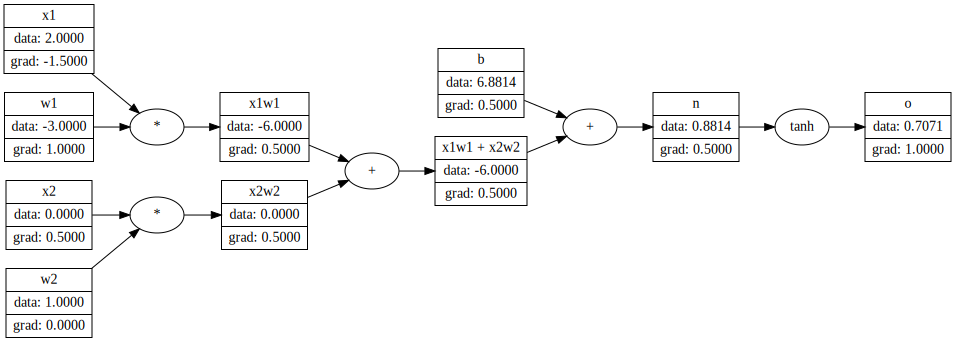

In [39]:
o.backward()
draw_graph(o)

We can build the same calculation graph in [PyTorch](https://github.com/pytorch/pytorch) and have it calculate the gradients, if they match ours, we can be sure that our backpropagation implementation is working:

In [40]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad_()
x2 = torch.Tensor([0.0]).double(); x2.requires_grad_()
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad_()
w2 = torch.Tensor([1.0]).double(); w2.requires_grad_()
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad_()
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print(f"x1 = {x1.grad.item()}")
print(f"w1 = {w1.grad.item()}")
print(f"x2 = {x2.grad.item()}")
print(f"w2 = {w2.grad.item()}")

0.7071066904050358
---
x1 = -1.5000003851533106
w1 = 1.0000002567688737
x2 = 0.5000001283844369
w2 = 0.0


The PyTorch gradients match the ones in our graph visualization above! Now that we can trust our implementation, let's start building some structures that will allow us to easily create a [Multilayer Perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) (jargon for a network with at least 3 layers, including the input and output layers).

Let's start by buiding a `Neuron`, which will perform the same operations as our calculation graph above:

In [41]:
import random

# Set seed so that we get same random values every time we run the notebook
random.seed(42)

class Neuron:
  def __init__(self, n_inputs):
    self.weights = [Node(random.uniform(-1, 1)) for _ in range(n_inputs)] # List of random weight values (one per input value)
    self.bias = Node(random.uniform(-1, 1)) # Random bias value to add to the neuron's activation

  def __call__(self, x):
    activation = sum([xi*wi for xi,wi in zip(x, self.weights)]) + self.bias # Multiply each input by its corresponding weight, sum up all the results, them add the bias to them
    output = activation.tanh() # Apply non-linearity to activation to produce output
    return output

x = [2.0, 3.0]     # Input with two values
neuron = Neuron(2) # Neuron that accepts to inputs
output = neuron(x) # Run inputs through neuron and get its output
output

Node(-0.9917317696727084)

Let's see how the inputs flow through our `Neuron`:

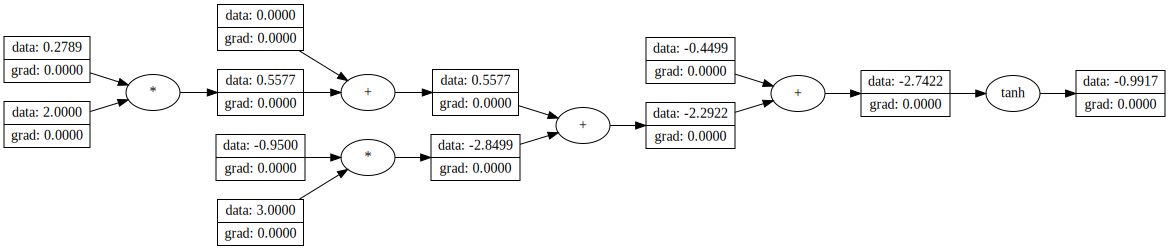

In [42]:
draw_graph(output)

A neural network has one or more layers of neurons, the inputs flow through each of these layers, with the output from each layer becoming the input for the next, with the output of the final layer representing the network's prediction.

Let's define the `Layer` class:

In [43]:
class Layer:
  def __init__(self, n_inputs, n_outputs):
    # Create list the same number of neurons as the requested number of outputs
    # (each neuron produces a single output), with each neuron being able to
    # receive the all the input values (each neuron has its independent set of
    # weights that are applied to each input value, allowing each neuron to learn
    # different things from the input)
    self.neurons = [Neuron(n_inputs) for _ in range(n_outputs)]

  def __call__(self, x):
    outs = [neuron(x) for neuron in self.neurons] # Run the input through each neuron to get a list of output values for this layer
    return outs[0] if len(outs) == 1 else outs    # For simplicity, in case there is a single output value, return a scalar, since this is what a single neuron returns

x = [2.0, 3.0]       # Input with two values
layer = Layer(2, 1)  # Layer expecting two input values and outputing a single value (thereby having a single neuron that accepts two input values)
output = layer(x)    # Run the input through the layer to get the output value
output

Node(0.5817270619168307)

If we plot the graph for the output again, we should get exactly the same graph because the `Layer` we instantiated had a single neuron:

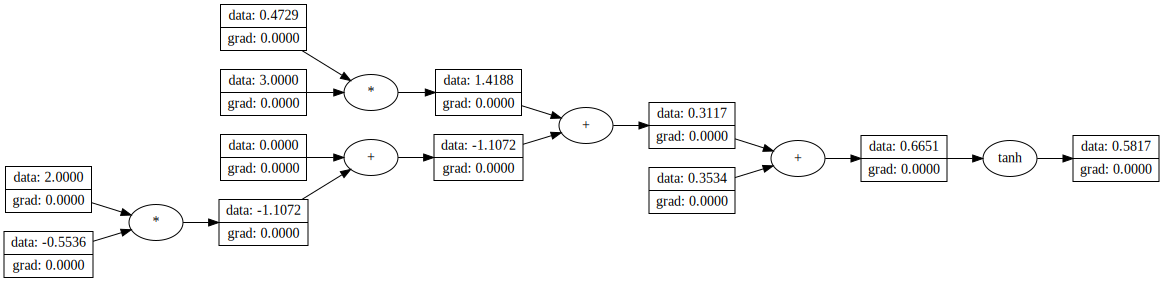

In [44]:
draw_graph(output)

Everything good so far! Time to define the **Multilayer Perceptron (MLP)** class, which we'll call `MLP`:

In [45]:
class MLP:
  def __init__(self, n_inputs, n_outputs):
    # Create a list of layers with the specified sizes, with the hidden layers
    # having the number of inputs as the last layers's number of outputs
    sizes = [n_inputs] + n_outputs
    self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(n_outputs))]

  def __call__(self, x):
    for layer in self.layers: x = layer(x) # Run the input through each layer to get the final network output
    return x

x = [2.0, 3.0, -1.0]    # Input with three values
mlp = MLP(3, [4, 4, 1]) # MLP that accepts an input with three values, then runs it through a layer with 4 neurons (input=3,output=4), another with 4 neurons (input=4,output=4), and a final one with one 1 neuron (input=4,output=1)
output = mlp(x)         # Run the input through the neural network to get the final output
output

Node(-0.538454785955258)

If we run the output through our visualization function we'll get a pretty convoluted graph, nevertheless representing the entire data flow of the neural network, from input to final output:

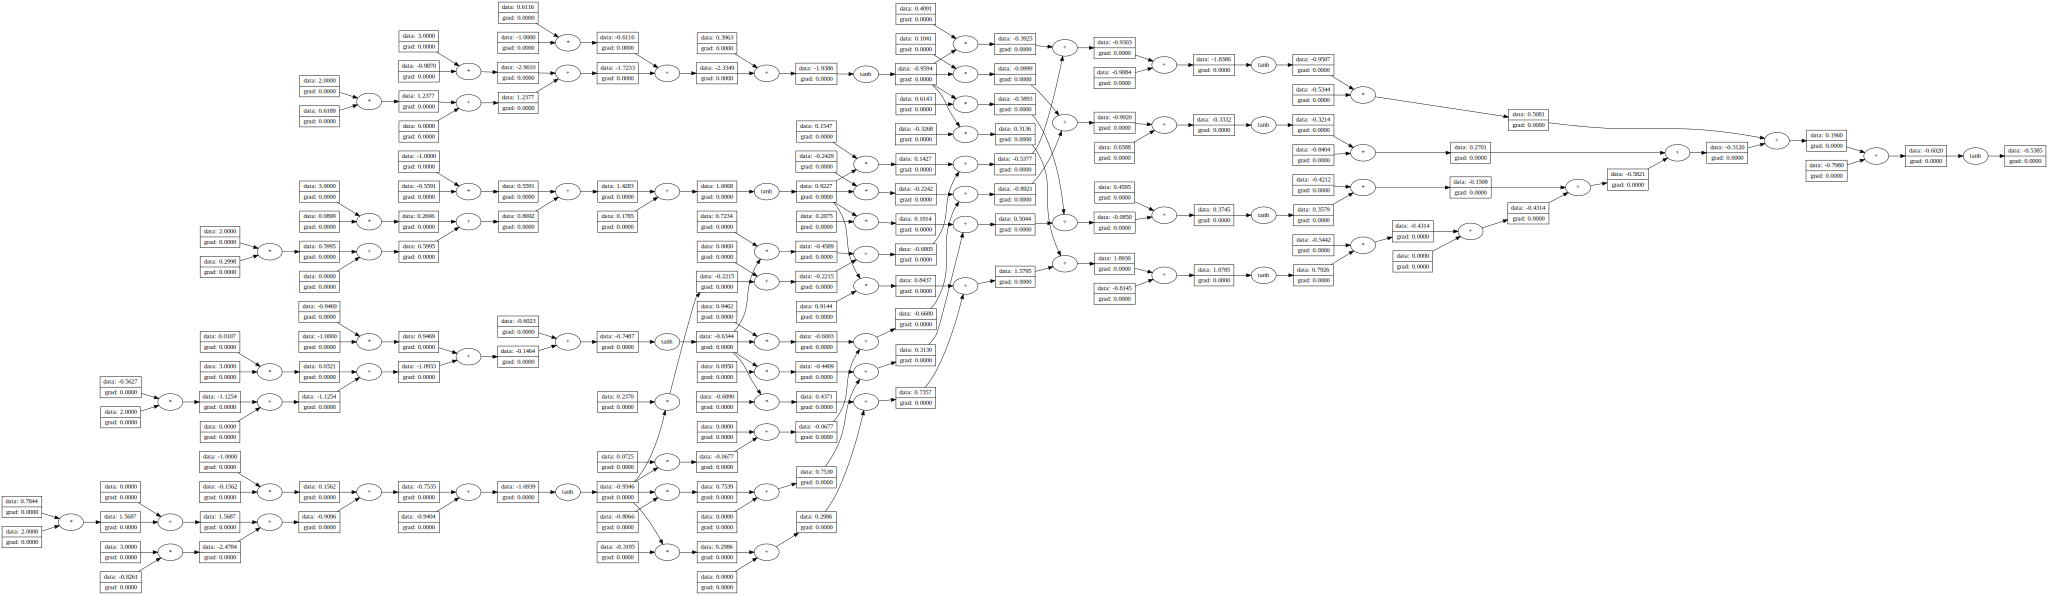

In [46]:
draw_graph(output)

## Creating a Dataset

Our **Multilayer Perceptron (MLP)** model is now ready to be trained. To proceed, we need to create a dataset for the learning task. The dataset will consist of 4 inputs, each containing 3 values. For each input, there will be a corresponding expected scalar output value. Our goal is to feed each input into the MLP and have the model produce a value that closely matches the expected output.

Let's create the dataset and run it through the network to observe the results:

In [47]:
xx = [
    [2.0, 3.0, -1.0], # First input
    [3.0, -1.0, 0.5], # Second input
    [0.5, 1.0, 1.0],  # Third input
    [1.0, 1.0, -1.0]  # Fourth input
]
yy = [
    1.0,  # Expected output for first input
    -1.0, # Expected output for second input
    -1.0, # Expected output for third input
    1.0   # Expected output for fourth input
]
y_predictions = [mlp(x) for x in xx]
y_predictions

[Node(-0.538454785955258),
 Node(0.017965494100465277),
 Node(-0.2926213471025997),
 Node(-0.7456251851483701)]

The model's predictions were mostly inaccurate, with some values being significantly off. For instance, the model predicted $-0.93$ for the first input, whereas the expected value was $1.0$. To improve the model, we need to quantify how far off its predictions are.

By quantifying the error, we can run backpropagation and use the resulting gradients to adjust the model's parameters through gradient descent. To do this, we'll create a [**loss function**](https://en.wikipedia.org/wiki/Loss_function). The loss function's value will approach $0.0$ when the model is accurate and $1.0$ when it's inaccurate. By minimizing this loss function using gradient descent, we aim to bring the model's predictions closer to the expected values in our dataset.

We'll use [**mean squared error**](https://en.wikipedia.org/wiki/Mean_squared_error) as our loss function. This function calculates the absolute distances between predictions and expected values, regardless of their signs, and amplifies the loss for larger distances. This asymmetry makes the model more sensitive to bigger errors, helping the gradients provide better signals and allowing us to converge to a well-performing model more quickly.

In [48]:
def mse_loss(yy, y_predictions):
  loss_params = [(y-y_prediction)**2 for y, y_prediction in zip(yy, y_predictions)]
  loss = sum(loss_params)
  return loss, loss_params
loss, loss_params = mse_loss(yy, y_predictions)
loss, loss_params

(Node(6.950688721207065),
 [Node(2.3668431284286386),
  Node(1.0362537471792044),
  Node(0.5003845585749408),
  Node(3.047207287024281)])

If you analyze the list of individual values for each parameter in the loss function, you'll notice that the largest contribution to the loss comes from the prediction that was furthest from our expectation—the output for the first input.

Let's run backpropagation on the loss:

In [49]:
loss.backward()

Notice how the neuron's weights and biases now have gradients assigned to them:

In [50]:
neuron = mlp.layers[0].neurons[0]
neuron.weights[0].grad, neuron.bias.grad

(-0.2341599074644901, -0.19444782365960925)

Let's just double check that the gradients were calculated for the entire graph (you'll also notice that the graph is bigger because it now includes the loss function calculation at the very end):

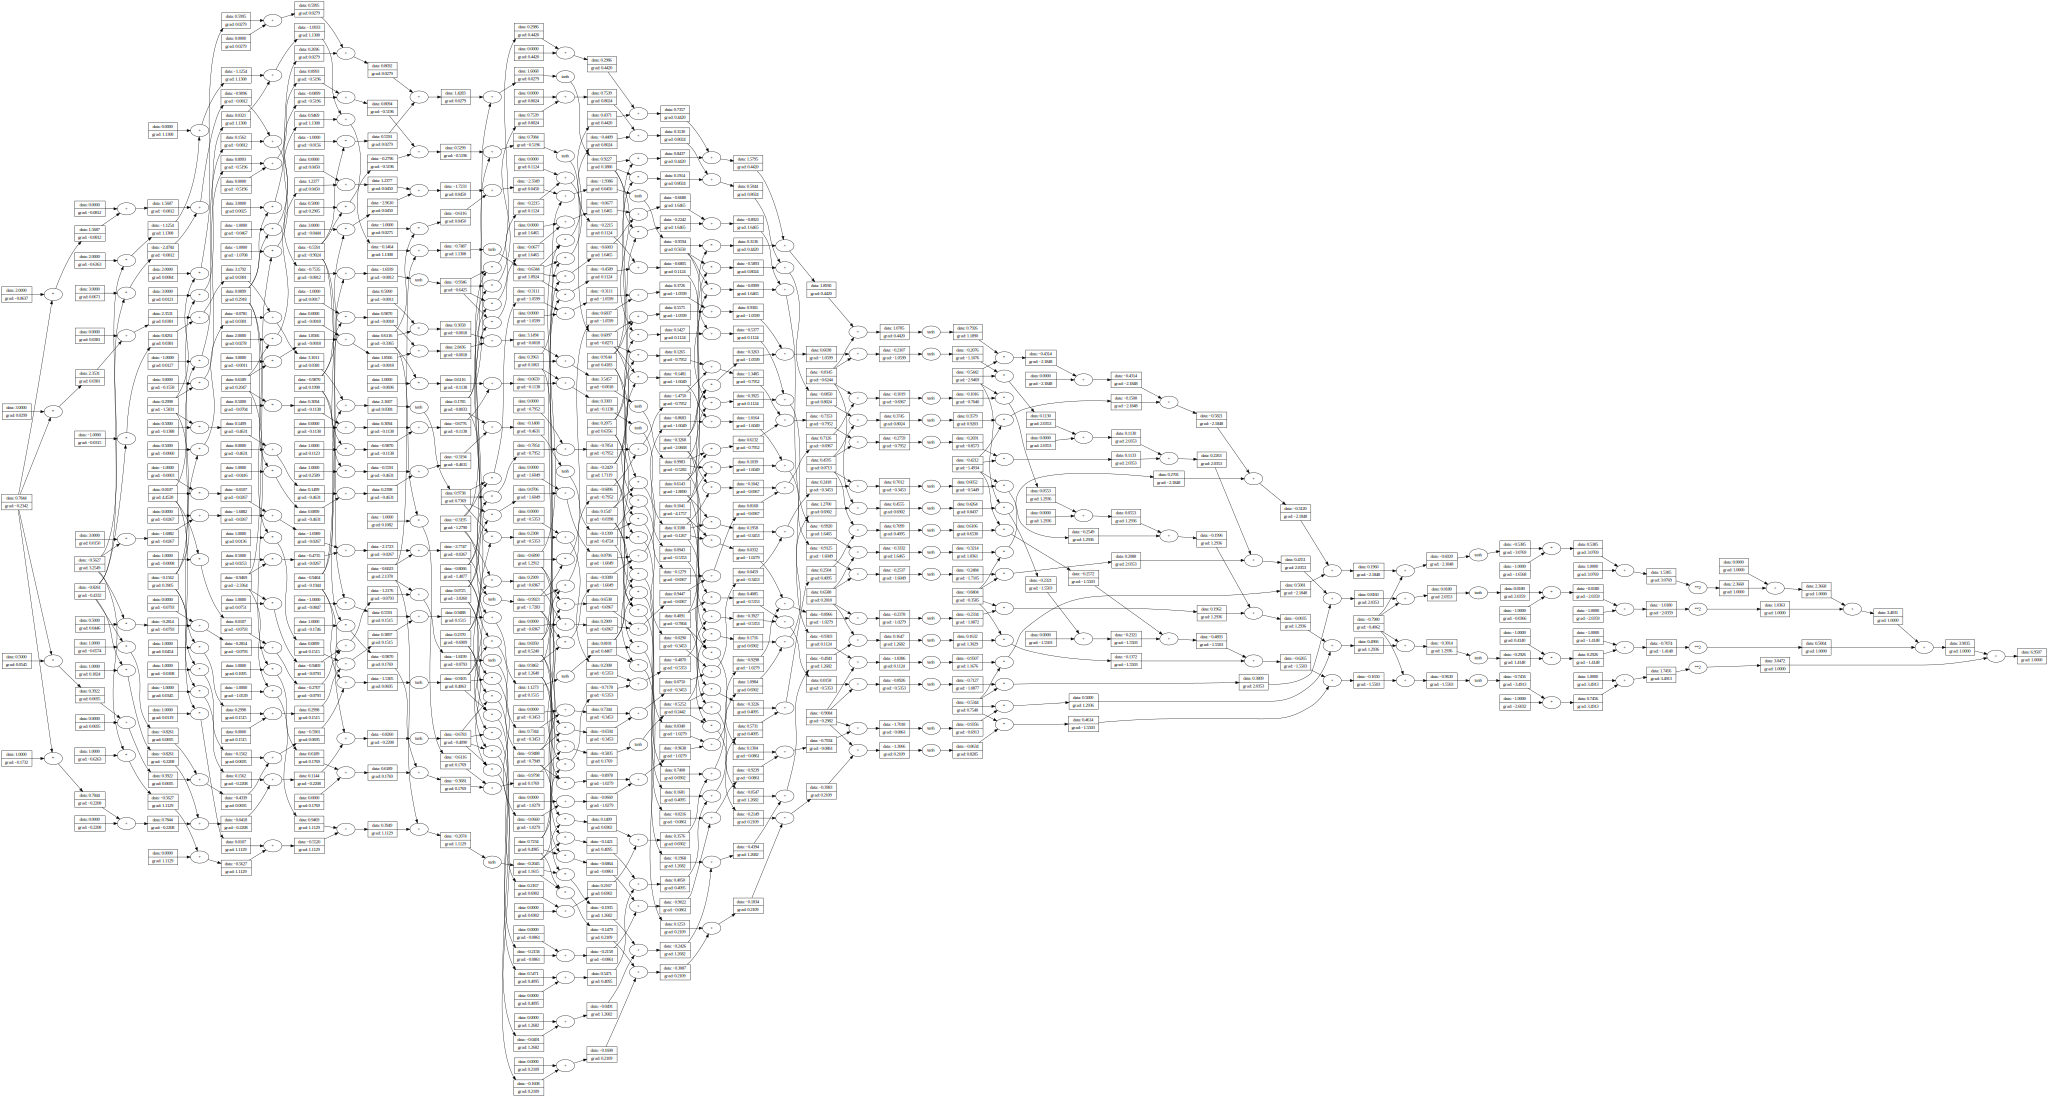

In [51]:
draw_graph(loss)

Now we just need to apply gradient descent to each parameter to make the loss smaller, thereby improving our model's predictions. To do that, it would be very helpful to have a single method that returns a list of all parameters in the model. Let's implement the `parameters()` function:

In [52]:
# Add parameters() method to `Neuron`
def _neuron_parameters(self):
  return self.weights + [self.bias] # Return the neuron's parameters
Neuron.parameters = _neuron_parameters

# Add parameters() method to `Layer`
def _layer_parameters(self):
  return [p for neuron in self.neurons for p in neuron.parameters()] # Return a single flat list with all the parameters from all neurons in the layer
Layer.parameters = _layer_parameters

# Add parameters() method to `MLP`
def _mlp_parameters(self):
  return [p for layer in self.layers for p in layer.parameters()] # Return a single flat list with all the parameters from all neurons in all layers
MLP.parameters = _mlp_parameters

# Let's reinstantiate the MLP to make the `parameters()` method
# we just monkey patched into the classes available:
x = [2.0, 3.0, -1.0]    # Input with three values
mlp = MLP(3, [4, 4, 1]) # MLP that accepts an input with three values, then runs it through a layer with 4 neurons (input=3,output=4), another with 4 neurons (input=4,output=4), and a final one with one 1 neuron (input=4,output=1)
output = mlp(x)         # Run the input through the neural network to get the final output

(
    len(mlp.parameters()), # The total number of model parameters
    mlp.parameters()       # The model parameters themselves
)

(41,
 [Node(-0.44405279377981577),
  Node(0.27136888852880037),
  Node(-0.2703356420598315),
  Node(-0.2596380657662347),
  Node(-0.5809859384570246),
  Node(-0.4660443559017733),
  Node(0.873309175424988),
  Node(0.2960707704931871),
  Node(0.21826201133397638),
  Node(-0.657722703603806),
  Node(0.45825359590069836),
  Node(-0.6731950124761432),
  Node(-0.24108911648470444),
  Node(0.9790467012731905),
  Node(0.2799995197081857),
  Node(0.11389948754929247),
  Node(0.3692285019797492),
  Node(0.6857038403796192),
  Node(0.5519998230924896),
  Node(-0.5419038560717913),
  Node(-0.9357995121919245),
  Node(-0.36909390388183616),
  Node(-0.46451824804859454),
  Node(-0.5780343128273471),
  Node(0.8858194286701089),
  Node(0.7527352529453377),
  Node(-0.37064423840304417),
  Node(0.3108773305897601),
  Node(-0.20873619787867148),
  Node(0.829095179481087),
  Node(-0.0822962948252024),
  Node(-0.4702396670038951),
  Node(-0.5067449846120331),
  Node(0.12273626832630158),
  Node(-0.4745167

With the full list of parameters, the next step is to iteratively run the calculations, compute the loss, backpropagate the gradients, adjust the parameters, and repeat this process until the desired loss is achieved. Let's implement a `train()` function to execute this algorithm:

In [53]:
def train(model, dataset, n_epochs, learning_rate=0.1, verbose=True):
  # Run backpropagation and gradient descent for N steps (aka epochs)
  for epoch in range(n_epochs):
      # First reset the gradients
      for p in model.parameters(): p.grad = 0.0

      # Run the inputs through the model to get its current predictions
      xx, yy = dataset

      for x, y in zip(xx, yy):
        y_pred = model(x)

        # Calculate the current loss (how far off are the predicted values from the expected ones)
        loss, _ = mse_loss([y], [y_pred])

        # Run backpropagation to calculate gradients of model parameters in respect to current loss
        loss.backward()

        # Perform a step of gradient descent by adjusting the value of
        # each parameter in the inverse direction of its gradient (scaled
        # by a learning rate that makes the step smaller to avoid overshooting
        # and stepping over the loss descent we are supposed to go down through)
        for p in model.parameters(): p.data -= learning_rate * p.grad

      # Print the current progress
      if verbose: print(f"epoch: {epoch}, loss: {loss.data}")

# Train the model for 10 steps
train(mlp, (xx, yy), 10)

epoch: 0, loss: 1.3004633086965078
epoch: 1, loss: 2.355874843347927
epoch: 2, loss: 0.03597918343331082
epoch: 3, loss: 0.01202214905421502
epoch: 4, loss: 0.02366860659188252
epoch: 5, loss: 0.012549780817143044
epoch: 6, loss: 0.009229066134883659
epoch: 7, loss: 0.0074141889646603025
epoch: 8, loss: 0.006251860080547032
epoch: 9, loss: 0.005436598218078336


After 10 steps (epochs), the loss is much smaller than before. Let's compare the current predictions of the model against their respective expected values:

In [54]:
import json

def test(model, dataset):
  xx, yy = dataset
  for x, y in zip(xx, yy):
    y_pred = mlp(x)
    print(f"expected: {y:.2f}, predicted = {y_pred.data:.2f}")

test(mlp, (xx, yy))

expected: 1.00, predicted = 0.93
expected: -1.00, predicted = -0.98
expected: -1.00, predicted = -0.92
expected: 1.00, predicted = 0.93


It worked! Our model is getting closer and closer to our predictions, but it could be even better, let's run it a lot longer this time:

In [55]:
train(mlp, (xx, yy), 10_000, verbose=False) # Train for 10k epochs
test(mlp, (xx, yy))

expected: 1.00, predicted = 1.00
expected: -1.00, predicted = -1.00
expected: -1.00, predicted = -1.00
expected: 1.00, predicted = 1.00


## Conclusion

We built a neural network from scratch, showing that even complex models are just simple math put together. Our DIY network might not break speed records, but it taught us how gradients lead to better predictions.

In the end, we demystified backpropagation and learned how small steps drive big improvements. If fancy frameworks get overwhelming, remember: you've got the skills to build one yourself. Keep those gradients flowing!

# Backprop from Scratch

## Introduction

This notebook is an attempt at reproing [Andrej Karpathy's](https://en.wikipedia.org/wiki/Andrej_Karpathy) implementation of [karpathy/micrograd](https://github.com/karpathy/micrograd) by following his excellent lesson [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0), where he goes through how to:

- Create a simple engine that tracks the calculations in a [neural network](https://en.wikipedia.org/wiki/Neural_network_(machine_learning));
- Feed inputs through the network to get its predictions;
- Check how far off the predictions are from the actual results ([loss calculation](https://en.wikipedia.org/wiki/Loss_function));
- Figure out how much each part of the calculation contributed to the final result ([gradient](https://en.wikipedia.org/wiki/Gradient) calculation using [backpropagation](https://en.wikipedia.org/wiki/Backpropagation));
- Adjust the network's settings to make its predictions more accurate (improving with [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)).

The purpose of this notebook is for my own self-learning, and shouldn't add much to the original lesson beyond extra verbosity.

## Understanding Derivatives

Derivatives are crucial for building and training neural networks. A derivative represents the slope of a function at a specific point, indicating how the function changes as its input varies.

Imagine walking through a valley:
- Descending: Negative derivative (altitude decreases)
- Valley floor: Zero derivative (no change in altitude)
- Ascending: Positive derivative (altitude increases)

In neural networks, derivatives guide parameter updates to reduce error. The error landscape is like our valley:
- Negative derivative: Increase parameter to reduce error
- Positive derivative: Decrease parameter to reduce error
- Zero derivative: Potential error minimum

Let's define a mathematical function representing one such valley:

In [111]:
def f(x):
    return 3*x**2 - 4*x + 5

f(3)

20

Now let's plot that function, and mark two points on it, in this case $f(-2)$ and  $f(-2/3)$:

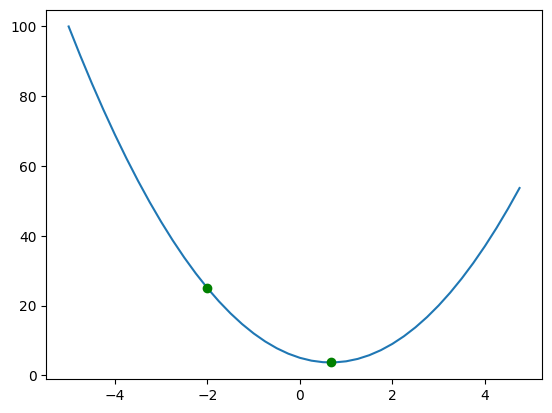

In [112]:
import numpy as np
import matplotlib.pyplot as plt

xx = np.arange(-5, 5, 0.25) # Create a range for x, between -5 and 5, split in increments of 0.25.
yy = f(xx) # Get the y values for that range
plt.plot(xx, yy) # Plot the function

plt.plot(-2, f(-2), 'go') # Point with descending slope (negative)
plt.plot(2/3, f(2/3), 'go') # Point where slope is horizontal (zero)

To find the slope of the function at $x = -2$, we can use the [forward difference method](https://en.wikipedia.org/wiki/Finite_difference). This involves calculating:

1. $f(-2)$
2. $f(-2 + h)$, where $h$ is a very small number (e.g. 0.000001)

The approximate derivative is then given by:

$\frac{f(-2 + h) - f(-2)}{h}$

This estimates the rate of change at $x = -2$ by examining how the function's value changes with a tiny increase in $x$. The smaller the $h$ value, the more accurate the approximation, though extremely small values may lead to precision issues in calculations.

Let's estimate the derivative of $f(x)$ when $x = -2$:

In [113]:
h = 0.0000001
x = -2
f(x), f(x+h), f(x+h)-f(x), (f(x+h)-f(x))/h, round((f(x+h)-f(x))/h)

(25, 24.99999840000003, -1.5999999689597644e-06, -15.999999689597644, -16)

Notice how the slope is negative, as expected, since that point is situated in a descending slope.

Now let's calculate it for $x = 2/3$:

In [114]:
h = 0.0000001
x = 2/3
f(x), f(x+h), f(x+h)-f(x), (f(x+h)-f(x))/h, round((f(x+h)-f(x))/h)

(3.666666666666667,
 3.6666666666666967,
 2.9753977059954195e-14,
 2.9753977059954195e-07,
 0)

The derivative is $0$, as expected, since the slope at that point is horizontal.

It would now be good to be able to visualize the derivative, so we need to determine the equation that represents it. Let's solve for that:

- $f(x) = 3x^2 - 4x + 5$ (the function we plotted)
- $f(x + h) - f(x) / h$ (the derivative formula)
- $(3(x + h)^2 - 4(x + h) + 5) - (3x^2 - 4x + 5)$
- $(3(x^2 + 2xh + h^2) - 4x - 4h + 5) - (3x^2 - 4x + 5)$
- $(3x^2 + 6xh + 3h^2 - 4x - 4h + 5) - (3x^2 - 4x + 5)$
- $3x^2 + 6xh + 3h^2 - 4x - 4h + 5 - 3x^2 + 4x - 5$
- $6xh + 3h^2 - 4h$
- $6x + 3h - 4$
- $6x + 3 * 0 - 4$ ($h$ is the smallest number possible that is close to $0$)
- $6x - 4$

The formula $6x - 4$ gives the exact slope of the function at any point, not an approximation like we did before. Let's use this exact derivative to double-check the values we approximated previously for $x = -2$ and $x = 2/3$:

In [115]:
def derivative_f(x):
    return 6 * x - 4

derivative_f(-2), derivative_f(2/3)

(-16, 0.0)

We got pretty much the same values as we did when we calculated them before, so the derivative equation is correct.

Let's use it to plot a line that is tangent to those points and has a slope matching their the respective derivatives at those points:

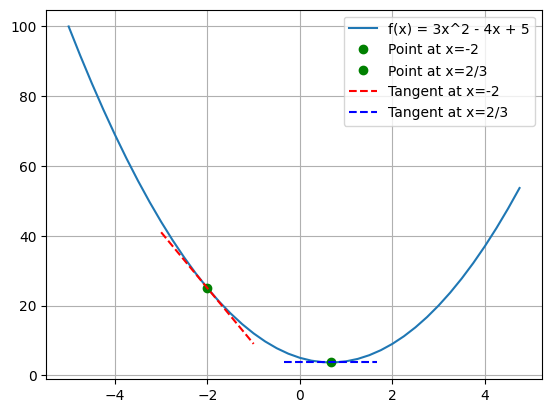

In [116]:
# Create a range for x, between -5 and 5, split in increments of 0.25
xx = np.arange(-5, 5, 0.25)
yy = f(xx)

# Plot the function
plt.plot(xx, yy, label='f(x) = 3x^2 - 4x + 5')

# Plot our points of interest
x1, x2 = -2, 2/3
y1, y2 = f(x1), f(x2)
plt.plot(x1, y1, 'go', label='Point at x=-2')
plt.plot(x2, y2, 'go', label='Point at x=2/3')

# Tangent line at x1
dy1 = derivative_f(x1)
tangent_x1 = np.linspace(x1-1, x1+1, 100)
tangent_y1 = y1 + dy1 * (tangent_x1 - x1)
plt.plot(tangent_x1, tangent_y1, 'r--', label='Tangent at x=-2')

# Tangent line at x2
dy2 = derivative_f(x2)
tangent_x2 = np.linspace(x2-1, x2+1, 100)
tangent_y2 = y2 + dy2 * (tangent_x2 - x2)
plt.plot(tangent_x2, tangent_y2, 'b--', label='Tangent at x=2/3')

plt.legend()
plt.grid(True)

## Building the Calculation Graph

We will now lay the foundations required for running [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) by building a calculation graph. This graph will track each step of a calculation and their dependencies, which is crucial for calculating the gradients of each parameter during backpropagation.

We can achieve this by creating a simple wrapper that encapsulates scalar values and uses operator overloading to build a dependency tree. In this notebook, this wrapper will be the `Node` class:

In [117]:
class Node:
    def __init__(self, data, children=(), op=None):
        self.data = data # The value of the variable
        self.children = set(children) # The nodes that produced this node's value after having an operation applied to them (eg: c = a + b)
        self.op = op # The operation applied on the children to produce this node
        self.label = None # The name of the node

    def __add__(self, other):
        # Return a new node instance that has the result of the op,
        # and tracks which nodes created it and with which op
        return Node(self.data + other.data, (self, other), op='+')

    def __repr__(self):
        label = f"{self.label} = " if self.label else ""
        children = f"; {self.op.join(child.label or str(child.data) for child in self.children)}" if self.children and any(child.label for child in self.children) else ""
        return f"Node({label}{self.data}{children})"

a = Node(5); a.label = "a"
b = Node(10); b.label = "b"
c = a + b; c.label = "c"
c

Node(c = 15; a+b)

Won't work for this though:

In [118]:
try: Node(5) + 5
except Exception as e: print(e)

'int' object has no attribute 'data'


`other` is an `int`, not a `Node`, that's why that didn't work.

Let's patch our `__add__` to cast the other value if necessary:

In [119]:
def __add__(self, other):
    other = other if isinstance(other, Node) else Node(other)
    return Node(self.data + other.data, (self, other), op='+')
Node.__add__ = __add__

Node(5) + 5

Node(10)

Works now! Won't work for this though:

In [120]:
try: 5 + Node(5)
except Exception as e: print(e)

unsupported operand type(s) for +: 'int' and 'Node'


Still solvable because Python will check both sides of the operator for an object with a function that can solve it:

In [121]:
def __radd__(self, other):
    return self + other # this was called with other + self, so by reversing the order we'll make the __add__ operator be called
Node.__radd__ = __radd__

5 + Node(5), Node(5) + 5

(Node(10), Node(10))

Let's add support for *multiplication* (pretty much the same pattern as overriding *addition*):

In [122]:
def __mul__(self, other):
    other = other if isinstance(other, Node) else Node(other)
    return Node(self.data * other.data, (self, other), op='*')
Node.__mul__ = __mul__

def __rmul__(self, other):
    return self * other
Node.__rmul__ = __rmul__

Node(10) * 2, 2 * Node(10)

(Node(20), Node(20))

Now we'll implement negation using *multiplication*, and then use that to implement *subtraction* by combining it with *addition*:

In [123]:
def __neg__(self):
   return self * -1 # implementing negation allows us to re-use the __add__ override
Node.__neg__ = __neg__

def __sub__(self, other):
    return self + (-other) # re-uses __add__ override
Node.__sub__ = __sub__

def __rsub__(self, other):
    return other + (-self) # re-uses __add__ override
Node.__rsub__ = __rsub__

Node(10) - 2, 2 - Node(10)

(Node(8), Node(-8))

And now *exponentiation*, and then use that along with *multiplication* to implement *division* (because $\frac{a}{b} = a \times b^{-1}$):

In [124]:
def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    return Node(self.data**other, (self,), f'**{other}')
Node.__pow__ = __pow__

def __truediv__(self, other): # self / other
    other = other if isinstance(other, Node) else Node(other)
    return self * other**-1
Node.__truediv__ = __truediv__

def __rtruediv__(self, other): # other / self
    other = other if isinstance(other, Node) else Node(other)
    return other * self**-1
Node.__rtruediv__ = __rtruediv__

Node(10) / 2, 2 / Node(10)

(Node(5.0), Node(0.2))

Now that we have support for mosth arithmetic operators, let's build a calculation graph for the formula $(a \times b + c) \times f$:

In [125]:
def create_calc():
  a = Node(2.0); a.label = "a"
  b = Node(-3.0); b.label = "b"
  c = Node(10.0); c.label = "c"
  e = a * b; e.label = "e"
  d = e + c; d.label = "d"
  f = Node(-2.0); f.label = "f"
  L = d * f; L.label = "L"
  return L

L = create_calc()
L

Node(L = -8.0; d*f)

Let's write some code to be able to visualize these graphs:

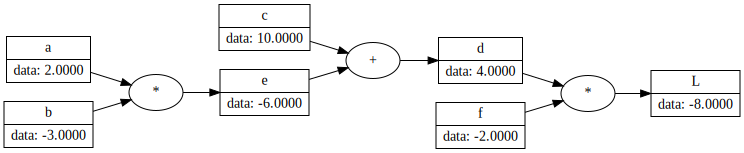

In [126]:
import graphviz

# Function to generate a label for a node in the graph. This label will include the node's label and data.
def _draw_graph__node_label(node):
    return f"{node.label}|data: {node.data:.4f}"

# Function to plot a computation graph, starting from the root node.
def draw_graph(root, format='svg', rankdir='LR'):
    # Helper function to trace through the computation graph, gathering nodes and edges.
    def _trace(root):
        nodes, edges = set(), set()  # Sets to store unique nodes and edges.

        # Recursive function to build the graph by traversing the computation nodes.
        def _build(v):
            if v not in nodes:  # If the node hasn't been added yet.
                nodes.add(v)  # Add the current node to the set of nodes.
                for child in v.children:  # Iterate through the children (dependencies) of the current node.
                    edges.add((child, v))  # Add an edge from the child to the current node.
                    _build(child)  # Recursively build the graph from the child node.

        _build(root)  # Start building the graph from the root node.
        return nodes, edges  # Return the sets of nodes and edges.

    # Ensure the graph's direction is either left-to-right ('LR') or top-to-bottom ('TB').
    assert rankdir in ['LR', 'TB']

    # Get the nodes and edges by tracing the graph starting from the root.
    nodes, edges = _trace(root)

    # Create a new Graphviz Digraph object with the specified format and rank direction.
    dot = graphviz.Digraph(format=format, graph_attr={'rankdir': rankdir})

    # Add each node to the graph.
    for n in nodes:
        node_label = _draw_graph__node_label(n)  # Generate the label for the node.
        dot.node(name=str(id(n)), label=node_label, shape='record')  # Add the node to the graph with its label.

        if n.op:  # If the node represents an operation (not a leaf node).
            dot.node(name=str(id(n)) + n.op, label=n.op)  # Add a separate node for the operation.
            dot.edge(str(id(n)) + n.op, str(id(n)))  # Connect the operation node to the main node.

    # Add edges between nodes based on the computation graph.
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)  # Draw an edge from n1 to the operation node of n2.

    return dot  # Return the final graph object for rendering.

draw_graph(L)

## Calculating Gradients with Backpropagation

The main reason we track the calculation graph is to figure out how much each part of the network contributed to the final result. To do so, we need to add support to track the partial derivatives (aka gradients) for each node in respect to the calculation result:

In [127]:
def __init__(self, data, children=(), op=None):
    self.data = data
    self.children = children
    self.op = op
    self.label = None
    self.grad = 0.0 # Gradients will be stored here
Node.__init__ = __init__

Let's also create a method `get_node()` to grab specific nodes from the calculation graph at any time (these aren't available globally since they are in the scope of the `create_calc()` function):

In [128]:
def get_node(self, labels):
  nodes_map = {}
  def _visit(node):
    for _node in node.children: _visit(_node)
    nodes_map[node.label] = node
  _visit(self)
  nodes = [nodes_map.get(label) for label in labels]
  nodes = nodes[0] if len(nodes) == 1 else nodes
  return nodes
Node.get_node = get_node

And while we're at it let's create a method `get_nodes()` that returns all nodes in the graph listed from first to last (will be useful later):

In [129]:
def _node_get_nodes(self):
  node_list, visited = [], set()
  def _dfs(v):
    if v not in visited:
      visited.add(v)
      for child in v.children:
        _dfs(child)
      node_list.append(v)
  _dfs(self)
  return node_list
Node.get_nodes = _node_get_nodes

L = create_calc()
L.get_nodes()

[Node(a = 2.0),
 Node(b = -3.0),
 Node(e = -6.0; a*b),
 Node(c = 10.0),
 Node(d = 4.0; e+c),
 Node(f = -2.0),
 Node(L = -8.0; d*f)]

And now let's get our hands dirty by manually calculating the gradients for all the nodes that led up to $L$.

First we initialize the gradient of $L$ to $1.0$; because if you change $L$ by $0.000001$, well... it changes by $0.000001$, duh! 😅

In [130]:
L = create_calc()
L.grad = 1.0
L

Node(L = -8.0; d*f)

To visualize how gradients are changing as we perform our calculations, let's add support for showing those in the visualizer:

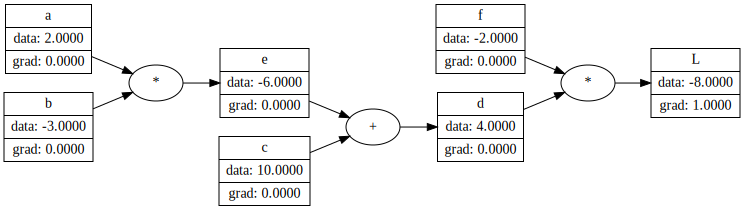

In [131]:
def _draw_graph__node_label(node): # This is an override of the labeling function we defined before
  return "|".join([x for x in [node.label, f"data: {node.data:.4f}", f"grad: {node.grad:.4f}"] if x])

draw_graph(L)

Now we need to calculate the partial derivative of $L$ (the result) with respect to $d$, mathematically described as $\frac{dL}{dd}$ (representing how the value of $d$ contributed to the value of $L$). Let's do it using the derivative formula we learned above:

- $L = d * f$  (Given)

- $\frac{dL}{dd} = ?$ (Objective)

- $\frac{f(x+h) - f(x)}{h} = \frac{(d+h) * f - d * f}{h}$  (Using the definition of the derivative)

- $\frac{d * f + h * f - d * f}{h}$  (Expand and simplify the expression)

- $\frac{h * f}{h} = f$  (Cancel out $h$ in the numerator and denominator)

- $\frac{dL}{dd} = f$  (Final result)

So the gradient of $d$ is the same as the value of $f$. This makes sense because, since this is a multiplication, changes to $d$ have an impact proportional to the value of $f$.

Let's set the gradient of $d$ to be the same as the value of $f$ then:

In [132]:
d, f = L.get_node(["d", "f"])
d.grad = f.data

It's kind of obvious now that the gradient for $f$ will be the value of $d$ for the very same reason, but let's go through the ropes:

- $L = d * f$  (Given)

- $\frac{dL}{df} = ?$ (Objective)

- $\frac{f(x+h) - f(x)}{h} = \frac{d * (f+h) - d * f}{h}$  (Using the definition of the derivative)

- $\frac{d * f + d * h - d * f}{h}$  (Expand and simplify the expression)

- $\frac{d * h}{h} = d$  (Cancel out $h$ in the numerator and denominator)

- $\frac{dL}{df} = d$  (Final result)

Confirmed! Let's set the gradient of $f$ to be the same as the value of $d$:

In [133]:
f = L.get_node("f")
f.grad = d.data

The first level of our backward pass is complete, let's check our status:

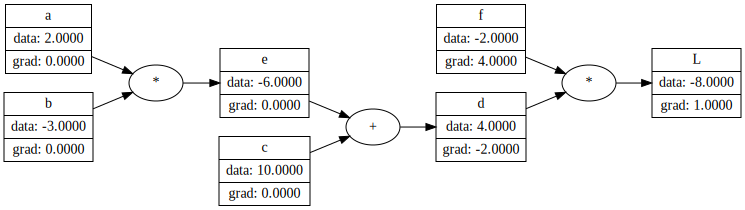

In [134]:
draw_graph(L)

Just for the sake of verbosity, let's also approximate the gradients numerically just to be sure that the numbers add up. We're going to calculate $\frac{dL}{dd}$ and $\frac{dL}{df}$, and its values should be exactly the same as the ones that ended up in the visualization above:

In [135]:
# Let's redefine our calculation factory to be more flexible,
# allowing us to adjust the node values on creation
def create_calc(ops = {}):
  def _node(label, value):
    value = ops.get(label, lambda x: x)(value)
    node = value if isinstance(value, Node) else Node(value)
    node.label = label
    return node

  a = _node("a", 2.0)
  b = _node("b", -3.0)
  c = _node("c", 10.0)
  e = _node("e", a * b)
  d = _node("d", e + c)
  f = _node("f", -2.0)
  L = _node("L", d * f)
  return L

# And now let's create a function that calculates the actual partial
# derivative value for any parameter of a calculation graph
def calc_dLd(param):
  # Calculate f(x)
  L1 = create_calc()

  # Calculate f(x + h)
  h = 0.000001
  L2 = create_calc({param : lambda x: x + h})

  # Calculate (f(x + h) - f(x)) / h
  return (L2 - L1) / h

(
  create_calc({"a" : lambda x: 10}), # Double check the method modification worked
  calc_dLd("d"), # Calculate dL/dd
  calc_dLd("f")  # Calculate dL/df
)

(Node(L = 40.0; d*f), Node(-2.000000000279556), Node(3.9999999996709334))

Double checked! Nevermind the $\frac{dL}{df} = 3.999...$, this is merely a consequence of floating number calculations not having infinite precision; the hardware returned the closest number it can represent.

Moving on to the next step, let's now calculate the gradient for $e$ with respect to $L$, aka $\frac{dL}{de}$.

This is where the [**chain rule**](https://en.wikipedia.org/wiki/Chain_rule) comes in, a key concept in backpropagation. The chain rule allows us to propagate gradients backward through the network, enabling the calculation of derivatives of the loss function with respect to each parameter. It tells us that $\frac{dL}{de} = \frac{de}{dd} \times \frac{dL}{dd}$, meaning that we can calculate the derivatives in respect to the result for a certain parameter as long as we calculated the one that came immediately before it.

With that knowledge in hand, let's calculate the local derivative $\frac{de}{dd}$ first:

- $d = e + c$ (Given)

- $\frac{dd}{de} = ?$ (Objective)

- $\frac{f(x + h) - f(x)}{h} = \frac{(e + h + c) - (e + c)}{h}$ (Using the definition of the derivative)

- $\frac{e + h + c - e - c}{h}$ (Expand and simplify the expression)

- $\frac{h}{h} = 1$ (Cancel out $h$ in the numerator and denominator)

- $\frac{dd}{de} = 1$ (Final result)

And now we can calculate $\frac{dL}{de}$ using the **chain rule**:

- $\frac{dd}{de} = 1$ (Given)

- $\frac{dL}{dd} = -2$ (Given)

- $\frac{dL}{de} = \frac{dd}{de} \times \frac{dL}{dd}$ (Chain rule)

- $\frac{dL}{de} = 1 \times -2 = -2$ (Final solution)

This means that the gradient from the node that results from the *addition* computation was propagated to this node, this is because the local derivative of a variable in an *addition* operation is always *1*. For this reason, whenever you find an *addition* operation, gradients are copied from the result to the operation's terms.

Let's set the gradients of $e$ and $c$ to be the same as the gradient of $d$:

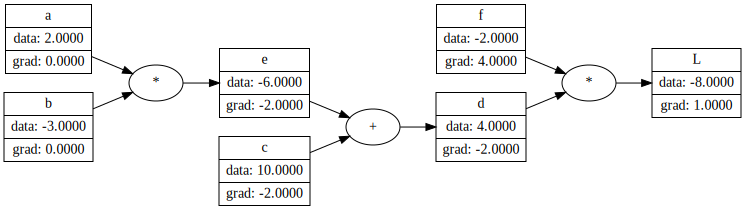

In [136]:
c,e,d = L.get_node(["c", "e", "d"])
e.grad = d.grad
c.grad = d.grad

draw_graph(L)

Time for a double check:

In [137]:
calc_dLd("e"), calc_dLd("c")

(Node(-2.000000000279556), Node(-1.999999998503199))

Double checked, we got the same values as in the graph visualization above (again, nevermind the precision errors).

And now we're almost there, just need to calculate $\frac{dL}{da}$ and $\frac{dL}{db}$.
You know the drill, we can do it because we already know $\frac{dL}{de}$.

**Chain rule** time, first let's calculate $\frac{dL}{da}$:

- $e = a \times b$ (Given)

- $\frac{de}{da} = \frac{e(a + h, b) - e(a, b)}{h}$ (Using the definition of the derivative)

- $\frac{de}{da} = \frac{((a + h) * b) - (a \times b)}{h}$ (Substitute $e = a \times b$)

- $\frac{de}{da} = \frac{a \times b + h \times b - a * b}{h}$ (Expand and simplify the expression)

- $\frac{de}{da} = \frac{h \times b}{h}$ (Simplify further)

- $\frac{de}{da} = b$ (Local derivative result)

- $\frac{dL}{da} = \frac{de}{da} \times \frac{dL}{de}$ (Chain rule)

- $\frac{dL}{da} = b \times \frac{dL}{de}$ (Final result)

And now for $\frac{dL}{db}$:

- $\frac{de}{db} = \frac{e(a, b + h) - e(a, b)}{h}$ (Using the definition of the derivative)

- $\frac{de}{db} = \frac{a \times (b + h) - a \times b}{h}$ (Substitute $e = a \times b$)

- $\frac{de}{db} = \frac{a \times b + a \times h - a \times b}{h}$ (Expand and simplify the expression)

- $\frac{de}{db} = \frac{a \times h}{h}$ (Simplify further)

- $\frac{de}{db} = a$ (Local derivative result)

- $\frac{dL}{db} = \frac{de}{db} \times \frac{dL}{de}$ (Chain rule)

- $\frac{dL}{db} = a \times \frac{dL}{de}$ (Final result)

Let's apply the results to the nodes:

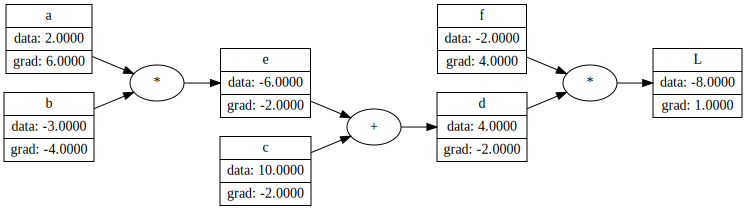

In [138]:
a, b, e = L.get_node(["a", "b", "e"])
a.grad = b.data * e.grad
b.grad = a.data * e.grad
draw_graph(L)

Final double check:

In [139]:
calc_dLd("a"), calc_dLd("b")

(Node(6.000000000838668), Node(-4.000000000559112))

Success! We have completed a full round of backpropagation, manually calculated step by step!

## Performing Gradient Descent

[Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) is a key optimization technique for training neural networks. It iteratively updates the model's parameters to minimize the loss function and improve prediction accuracy.

To perform gradient descent, we adjust the model's parameters by subtracting the gradients multiplied by a factor called the [learning rate](https://en.wikipedia.org/wiki/Learning_rate). The gradient shows the direction of steepest ascent, and by moving in the opposite direction, we aim to reduce the loss. The learning rate controls the step size: a smaller rate means finer, more gradual adjustments, while a larger rate speeds up convergence but risks overshooting. The objective is to fine-tune parameters to minimize the loss effectively.

Let's update the parameter values using the gradients from our previous calculations:

In [140]:
a, b, c, d, e, f = L.get_node(["a", "b", "c", "d", "e", "f"])
learning_rate = 0.01
L = create_calc({
  "a" : lambda x: a.data - learning_rate * a.grad,
  "b" : lambda x: b.data - learning_rate * b.grad,
  "c" : lambda x: c.data - learning_rate * c.grad,
  "d" : lambda x: d.data - learning_rate * d.grad,
  "e" : lambda x: e.data - learning_rate * e.grad,
  "f" : lambda x: f.data - learning_rate * f.grad
})
L

Node(L = -8.2008; d*f)

Notice how *L* is now $-8.2008$ instead of $-8.0$. It's a smaller number, as expected, meaning we were able to adjust the variables of our calculation to produce a result that is smaller than the previous one.

This is all we need to be able to train a neural network; when the result of the calculation is the loss, we need only to:
- Keep showing inputs to the network by setting them as the values of the variables at the start of calculation graph (eg: $a$ and $b$);
- Propagate them through the graph all the way to the end (forward pass);
- Calculate the loss function (more on this later, this will be the final node of the calculation graph);
- Backpropagate to find the gradients for each parameter;
- Do a gradient descent step to adjust the parameters;
- Rinse and repeat until we achieve the desired loss.


## Automating Backpropagation

Let's now implement the backpropagation step so that we don't have to manually calculate gradients anymore.

First we need to make sure that all nodes that result from an *addition* operation know how to backpropagate their gradients. Remember, in an addition operation, the gradients for the input nodes are the same as the gradient of the result:

In [141]:
def __add__(self, other):
    other = other if isinstance(other, Node) else Node(other)
    out = Node(self.data + other.data, (self, other), "+")

    def _backward():
        self.grad += out.grad # set the gradient of the result in the left term of the operation
        other.grad += out.grad  # set the gradient of the result in the right term of the operation
    out._backward = _backward

    return out
Node.__add__ = __add__

And now for the *multiplication*, the gradient is proportional to the other term's value:

In [142]:
def __mul__(self, other):
    other = other if isinstance(other, Node) else Node(other)
    out = Node(self.data * other.data, (self, other), "*")

    def _backward():
        # The local derivative of the multiplication in respect to one of its terms
        # is the same as the data of the other term (eg: self.grad = other.data),
        # multiplying by `out.grad` we are using the chain rule to calculate
        # the partial derivative of term in respect to the graph's result value (eg: loss)
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = _backward

    return out
Node.__mul__ = __mul__

And finally for *exponentiation*:

In [143]:
def __pow__(self, other):
    assert isinstance(other, (int, float)), "second term must be int or float"
    x = self.data
    out = Node(x**other, (self,), f'**{other}')

    def _backward():
        # The local derivative of the power function (x^n) with respect to x is (n * x^(n-1)).
        # Therefore, to compute the gradient of x with respect to the final output (out),
        # we multiply the local derivative by `out.grad` using the chain rule.
        self.grad += (other * x**(other-1)) * out.grad
    out._backward = _backward

    return out
Node.__pow__ = __pow__

Now we can make nodes have a `backward()` method that calculates the gradient from the last node all the way back to the inputs by using the **chain rule**:

In [144]:
def backward(self):
    self.grad = 1.0
    nodes = self.get_nodes()
    for node in reversed(nodes): # Backpropagate from the end result node to the input nodes
      if not hasattr(node, "_backward"): continue
      node._backward()
Node.backward = backward

We'll now perform backpropagation using `backward()`, and then do manual gradient descent using the calculated gradients:

In [145]:
L = create_calc() # perform the calculation
L.backward() # do backpropagation
a, b, c, d, e, f = L.get_node(["a", "b", "c", "d", "e", "f"]) # fetch the nodes to get the gradients

# apply the gradients to the current values
learning_rate = 0.01
L = create_calc({
  "a" : lambda x: a.data - learning_rate * a.grad,
  "b" : lambda x: b.data - learning_rate * b.grad,
  "c" : lambda x: c.data - learning_rate * c.grad,
  "d" : lambda x: d.data - learning_rate * d.grad,
  "e" : lambda x: e.data - learning_rate * e.grad,
  "f" : lambda x: f.data - learning_rate * f.grad
})
L

Node(L = -8.2008; d*f)

We got $L = -8.2008$ which is exactly the same result we got when we performed the this pass manually before, meaning that our `backward()` method seems to be working.

## Building a Neural Network

Neural networks have layers of connected neurons that process data from input to output. Each neuron takes in inputs, multiplies them by weights, sums them up, and then applies a non-linear activation function to produce an output. This combination of linear and non-linear operations allows neural networks to model complex functions.

A crucial part of designing a neural network is choosing the right activation function. Here, we'll use the `tanh` function. Let's plot it to visualize how it behaves:

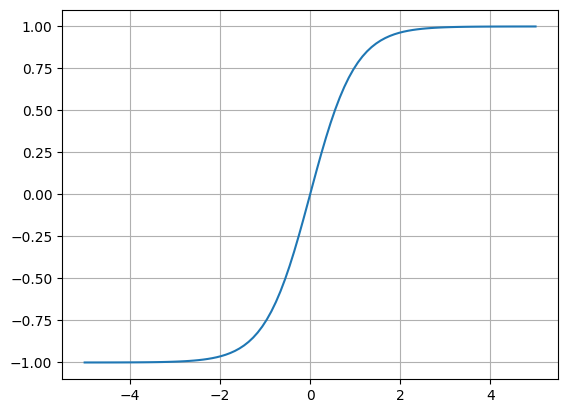

In [146]:
xx = np.linspace(-5, 5, 100) # create a list of 100 points from -5 to 5
yy = np.tanh(xx) # get the y values for each of the x values we generated before
plt.plot(xx, yy) # plot the tanh function
plt.grid(True) # enable plot grid

The `tanh` function is well-suited for neural networks because it is zero-centered, meaning it outputs values symmetrically between `[-1, 1]`. This non-linearity enables the network to learn complex patterns, while the zero-centered output helps stabilize and speed up training by preventing extreme values.

Let's add `tanh` our `Node` class:

In [147]:
import math

def tanh(self):
    # Calculate the tanh value and create
    # the node representing the operation
    x = self.data
    tanh = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
    out = Node(tanh, (self,), 'tanh')

    def _backward():
        # The derivative of tanh(x) in respect to x is (1 - tanh(x)^2),
        # multiplying by `out.grad` we are using the chain rule to calculate
        # the derivative of tanh(x) in respect to the graph's result value (eg: loss)
        self.grad += (1 - tanh ** 2) * out.grad
    out._backward = _backward

    return out
Node.tanh = tanh

Let's create a calculation graph resembling a neural network. We'll define *inputs*, *weights*, and *biases*, then perform the following steps:

1. Multiply the *inputs* by the *weights*.
2. Sum the results.
3. Add the *bias*.
4. Pass the output through the $tanh$ function to squash the activation into a standard range.

This process simulates the flow from input to activation in a single neuron. Here's the code:

In [148]:
# inputs
x1 = Node(2.0); x1.label = "x1";
x2 = Node(0.0); x2.label = "x2";

# weights
w1 = Node(-3.0); w1.label = "w1";
w2 = Node(1.0); w2.label = "w2";

# bias
b = Node(6.8813735870195432); b.label = "b";

# propagate inputs through neuron
x1w1 = x1 * w1; x1w1.label = "x1w1";
x2w2 = x2 * w2; x2w2.label = "x2w2";
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2";
n = x1w1x2w2 + b; n.label = "n"; # add bias
o = n.tanh(); o.label = "o"; # run activation function
o

Node(o = 0.7071067811865476; n)

Now let's backpropagate the result and plot the graph to see the structure and how the resulting gradients were successfully calculated:

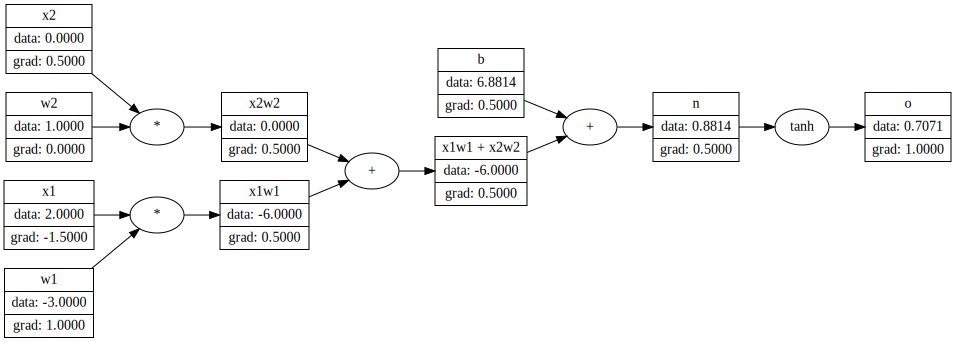

In [149]:
o.backward()
draw_graph(o)

We can build the same calculation graph in [PyTorch](https://github.com/pytorch/pytorch) and have it calculate the gradients, if they match ours, we can be sure that our backpropagation implementation is working:

In [150]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad_()
x2 = torch.Tensor([0.0]).double(); x2.requires_grad_()
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad_()
w2 = torch.Tensor([1.0]).double(); w2.requires_grad_()
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad_()
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print(f"x1 = {x1.grad.item()}")
print(f"w1 = {w1.grad.item()}")
print(f"x2 = {x2.grad.item()}")
print(f"w2 = {w2.grad.item()}")

0.7071066904050358
---
x1 = -1.5000003851533106
w1 = 1.0000002567688737
x2 = 0.5000001283844369
w2 = 0.0


The PyTorch gradients match the ones in our graph visualization above! Now that we can trust our implementation, let's start building some structures that will allow us to easily create a [Multilayer Perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) (jargon for a network with at least 3 layers, including the input and output layers).

Let's start by buiding a `Neuron`, which will perform the same operations as our calculation graph above:

In [151]:
import random

# Set seed so that we get same random values every time we run the notebook
random.seed(42)

class Neuron:
  def __init__(self, n_inputs):
    self.weights = [Node(random.uniform(-1, 1)) for _ in range(n_inputs)] # List of random weight values (one per input value)
    self.bias = Node(random.uniform(-1, 1)) # Random bias value to add to the neuron's activation

  def __call__(self, x):
    activation = sum([xi*wi for xi,wi in zip(x, self.weights)]) + self.bias # Multiply each input by its corresponding weight, sum up all the results, them add the bias to them
    output = activation.tanh() # Apply non-linearity to activation to produce output
    return output

x = [2.0, 3.0]     # Input with two values
neuron = Neuron(2) # Neuron that accepts to inputs
output = neuron(x) # Run inputs through neuron and get its output
output

Node(-0.9917317696727084)

Let's see how the inputs flow through our `Neuron`:

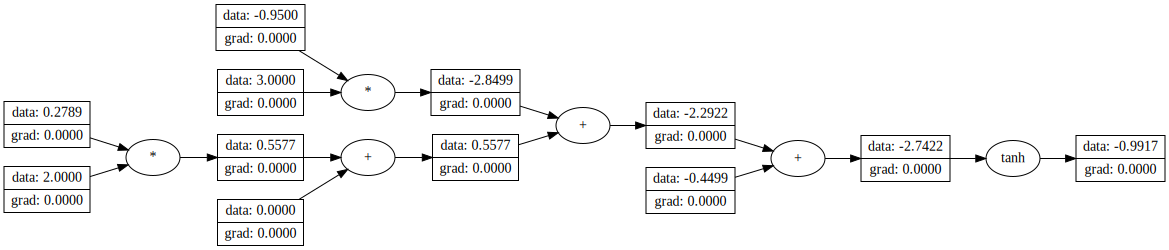

In [152]:
draw_graph(output)

A neural network has one or more layers of neurons, the inputs flow through each of these layers, with the output from each layer becoming the input for the next, with the output of the final layer representing the network's prediction.

Let's define the `Layer` class:

In [153]:
class Layer:
  def __init__(self, n_inputs, n_outputs):
    # Create list the same number of neurons as the requested number of outputs
    # (each neuron produces a single output), with each neuron being able to
    # receive the all the input values (each neuron has its independent set of
    # weights that are applied to each input value, allowing each neuron to learn
    # different things from the input)
    self.neurons = [Neuron(n_inputs) for _ in range(n_outputs)]

  def __call__(self, x):
    outs = [neuron(x) for neuron in self.neurons] # Run the input through each neuron to get a list of output values for this layer
    return outs[0] if len(outs) == 1 else outs    # For simplicity, in case there is a single output value, return a scalar, since this is what a single neuron returns

x = [2.0, 3.0]       # Input with two values
layer = Layer(2, 1)  # Layer expecting two input values and outputing a single value (thereby having a single neuron that accepts two input values)
output = layer(x)    # Run the input through the layer to get the output value
output

Node(0.5817270619168307)

If we plot the graph for the output again, we should get exactly the same graph because the `Layer` we instantiated had a single neuron:

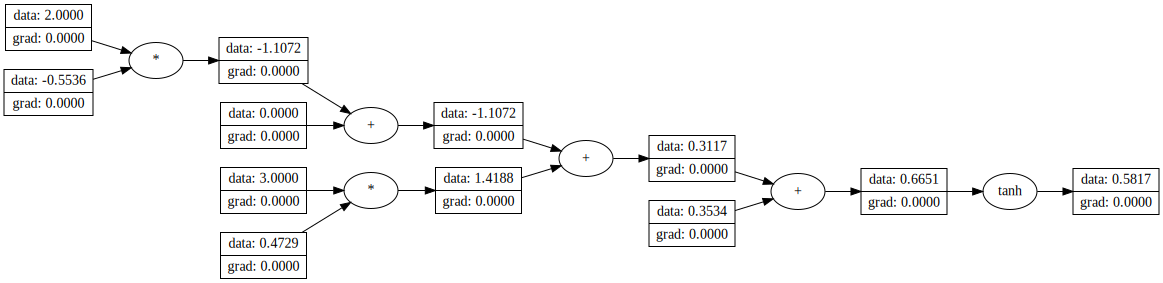

In [154]:
draw_graph(output)

Everything good so far! Time to define the **Multilayer Perceptron (MLP)** class, which we'll call `MLP`:

In [155]:
class MLP:
  def __init__(self, n_inputs, n_outputs):
    # Create a list of layers with the specified sizes, with the hidden layers
    # having the number of inputs as the last layers's number of outputs
    sizes = [n_inputs] + n_outputs
    self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(n_outputs))]

  def __call__(self, x):
    for layer in self.layers: x = layer(x) # Run the input through each layer to get the final network output
    return x

x = [2.0, 3.0, -1.0]    # Input with three values
mlp = MLP(3, [4, 4, 1]) # MLP that accepts an input with three values, then runs it through a layer with 4 neurons (input=3,output=4), another with 4 neurons (input=4,output=4), and a final one with one 1 neuron (input=4,output=1)
output = mlp(x)         # Run the input through the neural network to get the final output
output

Node(-0.538454785955258)

If we run the output through our visualization function we'll get a pretty convoluted graph, nevertheless representing the entire data flow of the neural network, from input to final output:

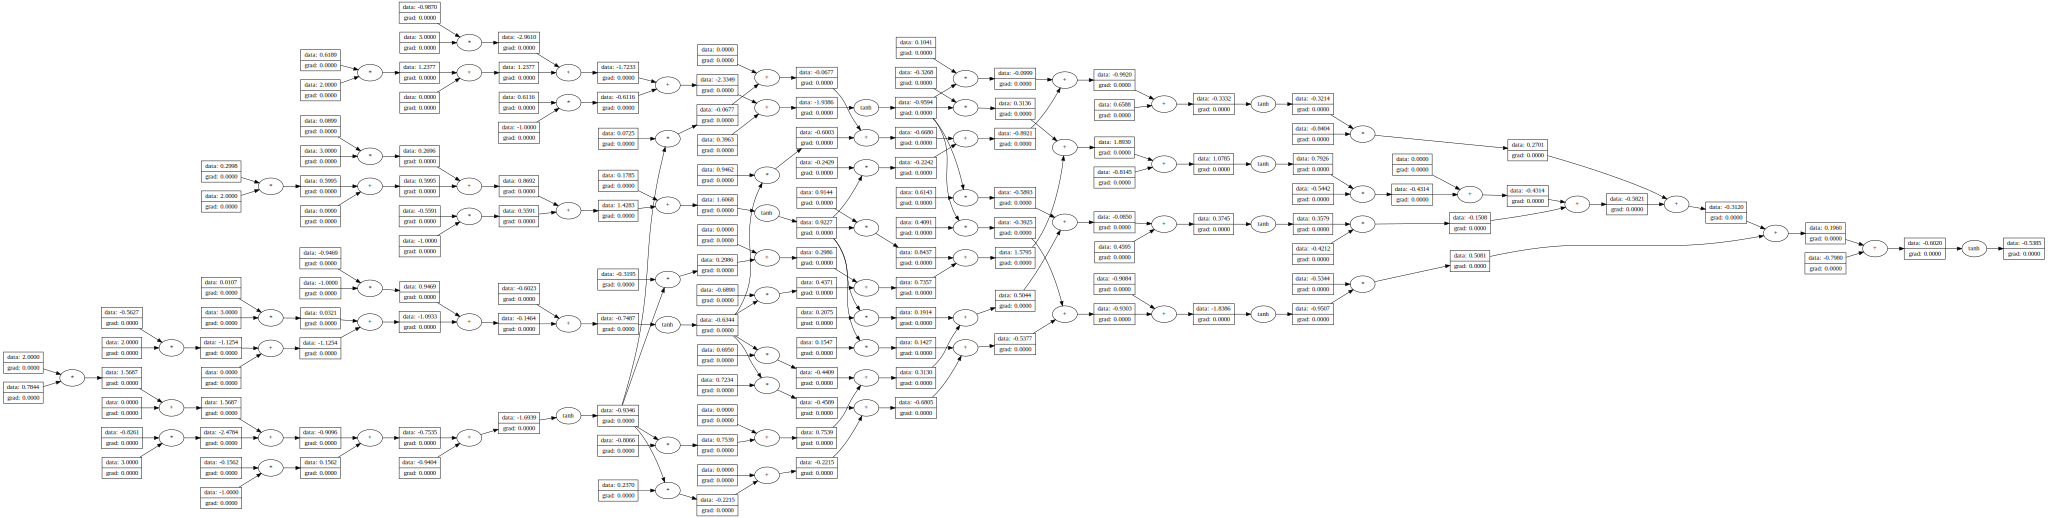

In [156]:
draw_graph(output)

## Creating a Dataset

Our **Multilayer Perceptron (MLP)** model is now ready to be trained. To proceed, we need to create a dataset for the learning task. The dataset will consist of 4 inputs, each containing 3 values. For each input, there will be a corresponding expected scalar output value. Our goal is to feed each input into the MLP and have the model produce a value that closely matches the expected output.

Let's create the dataset and run it through the network to observe the results:

In [157]:
xx = [
    [2.0, 3.0, -1.0], # First input
    [3.0, -1.0, 0.5], # Second input
    [0.5, 1.0, 1.0],  # Third input
    [1.0, 1.0, -1.0]  # Fourth input
]
yy = [
    1.0,  # Expected output for first input
    -1.0, # Expected output for second input
    -1.0, # Expected output for third input
    1.0   # Expected output for fourth input
]
y_predictions = [mlp(x) for x in xx]
y_predictions

[Node(-0.538454785955258),
 Node(0.017965494100465277),
 Node(-0.2926213471025997),
 Node(-0.7456251851483701)]

The model's predictions were mostly inaccurate, with some values being significantly off. For instance, the model predicted $-0.93$ for the first input, whereas the expected value was $1.0$. To improve the model, we need to quantify how far off its predictions are.

By quantifying the error, we can run backpropagation and use the resulting gradients to adjust the model's parameters through gradient descent. To do this, we'll create a [**loss function**](https://en.wikipedia.org/wiki/Loss_function). The loss function's value will approach $0.0$ when the model is accurate and $1.0$ when it's inaccurate. By minimizing this loss function using gradient descent, we aim to bring the model's predictions closer to the expected values in our dataset.

We'll use [**mean squared error**](https://en.wikipedia.org/wiki/Mean_squared_error) as our loss function. This function calculates the absolute distances between predictions and expected values, regardless of their signs, and amplifies the loss for larger distances. This asymmetry makes the model more sensitive to bigger errors, helping the gradients provide better signals and allowing us to converge to a well-performing model more quickly.

In [158]:
def mse_loss(yy, y_predictions):
  loss_params = [(y-y_prediction)**2 for y, y_prediction in zip(yy, y_predictions)]
  loss = sum(loss_params)
  return loss, loss_params
loss, loss_params = mse_loss(yy, y_predictions)
loss, loss_params

(Node(6.950688721207065),
 [Node(2.3668431284286386),
  Node(1.0362537471792044),
  Node(0.5003845585749408),
  Node(3.047207287024281)])

If you analyze the list of individual values for each parameter in the loss function, you'll notice that the largest contribution to the loss comes from the prediction that was furthest from our expectation—the output for the first input.

Let's run backpropagation on the loss:

In [159]:
loss.backward()

Notice how the neuron's weights and biases now have gradients assigned to them:

In [160]:
neuron = mlp.layers[0].neurons[0]
neuron.weights[0].grad, neuron.bias.grad

(-0.2341599074644901, -0.19444782365960925)

Let's just double check that the gradients were calculated for the entire graph (you'll also notice that the graph is bigger because it now includes the loss function calculation at the very end):

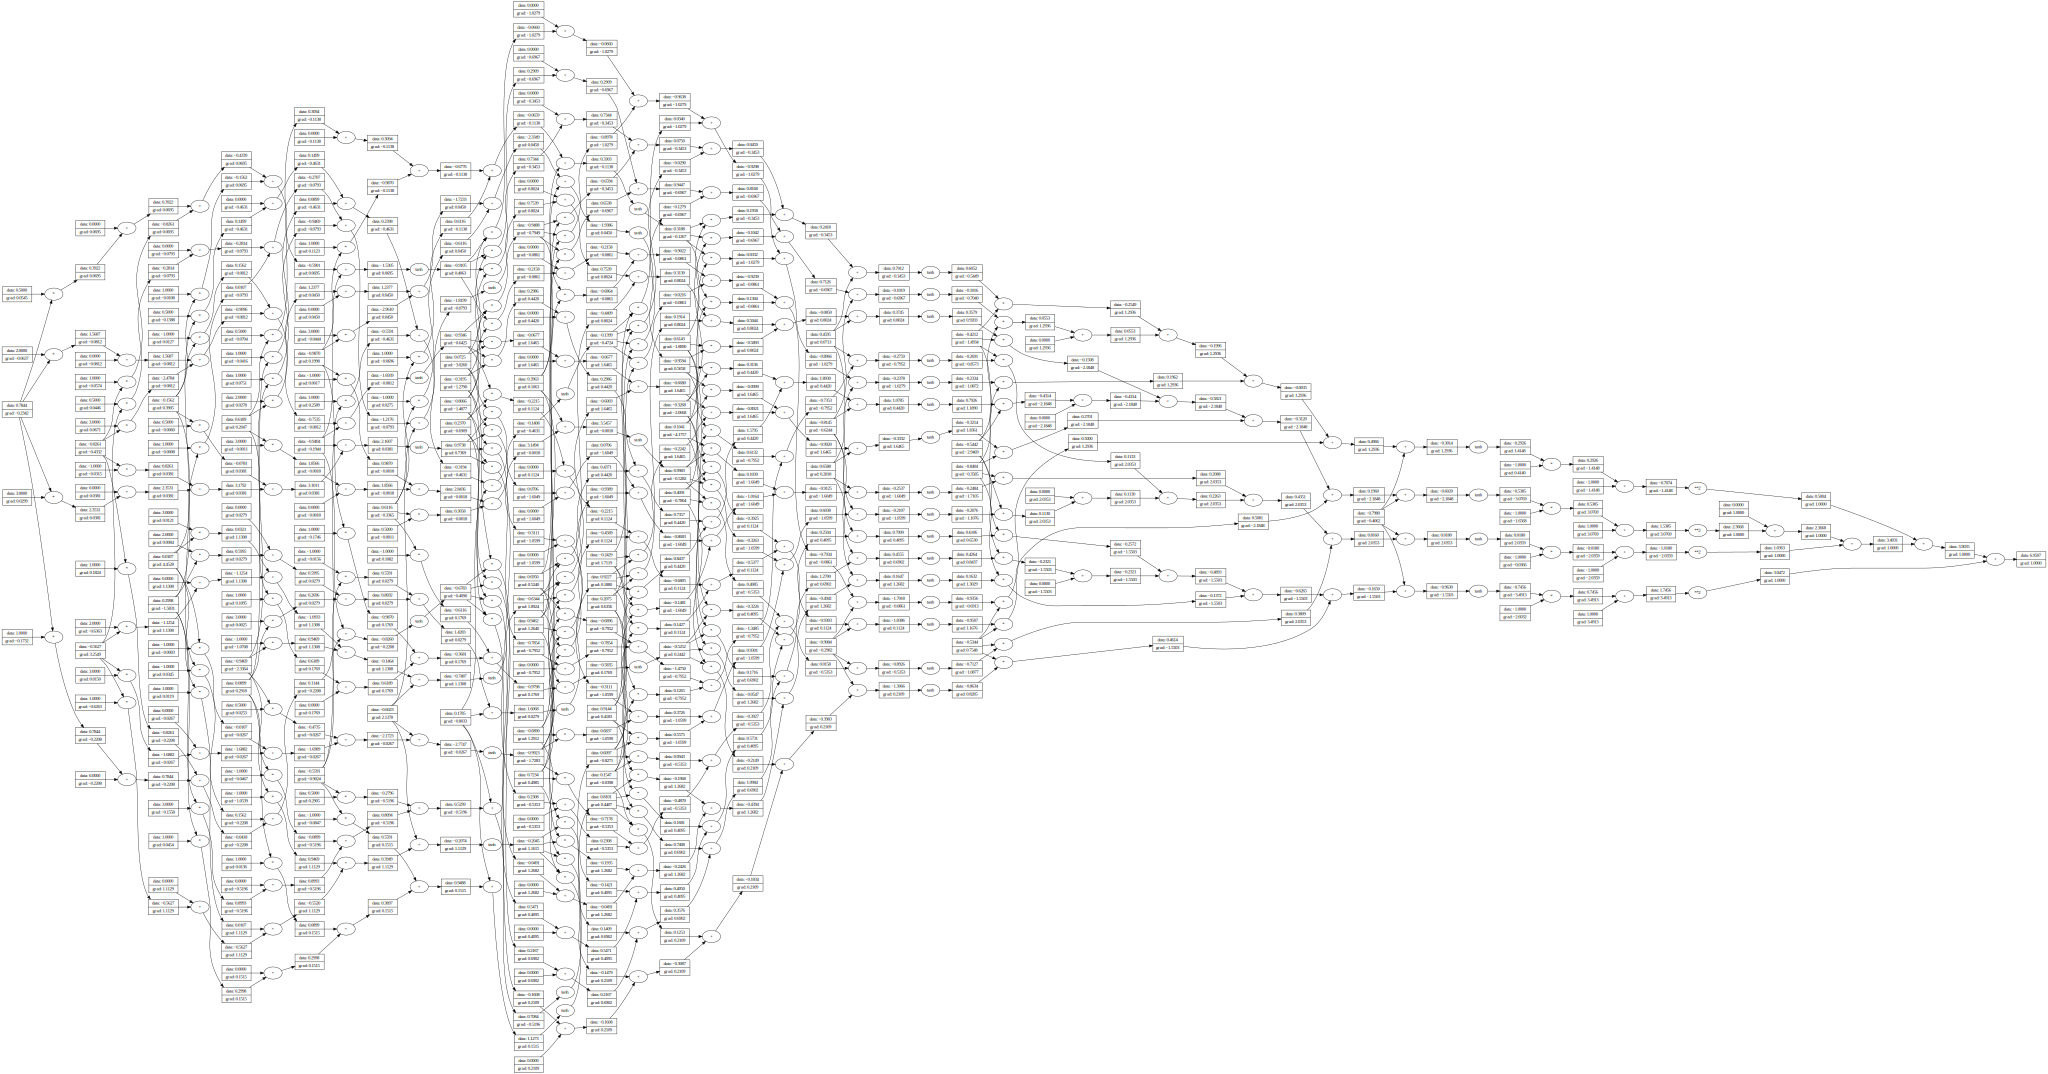

In [161]:
draw_graph(loss)

Now we just need to apply gradient descent to each parameter to make the loss smaller, thereby improving our model's predictions. To do that, it would be very helpful to have a single method that returns a list of all parameters in the model. Let's implement the `parameters()` function:

In [162]:
# Add parameters() method to `Neuron`
def _neuron_parameters(self):
  return self.weights + [self.bias] # Return the neuron's parameters
Neuron.parameters = _neuron_parameters

# Add parameters() method to `Layer`
def _layer_parameters(self):
  return [p for neuron in self.neurons for p in neuron.parameters()] # Return a single flat list with all the parameters from all neurons in the layer
Layer.parameters = _layer_parameters

# Add parameters() method to `MLP`
def _mlp_parameters(self):
  return [p for layer in self.layers for p in layer.parameters()] # Return a single flat list with all the parameters from all neurons in all layers
MLP.parameters = _mlp_parameters

# Let's reinstantiate the MLP to make the `parameters()` method
# we just monkey patched into the classes available:
x = [2.0, 3.0, -1.0]    # Input with three values
mlp = MLP(3, [4, 4, 1]) # MLP that accepts an input with three values, then runs it through a layer with 4 neurons (input=3,output=4), another with 4 neurons (input=4,output=4), and a final one with one 1 neuron (input=4,output=1)
output = mlp(x)         # Run the input through the neural network to get the final output

(
    len(mlp.parameters()), # The total number of model parameters
    mlp.parameters()       # The model parameters themselves
)

(41,
 [Node(-0.44405279377981577),
  Node(0.27136888852880037),
  Node(-0.2703356420598315),
  Node(-0.2596380657662347),
  Node(-0.5809859384570246),
  Node(-0.4660443559017733),
  Node(0.873309175424988),
  Node(0.2960707704931871),
  Node(0.21826201133397638),
  Node(-0.657722703603806),
  Node(0.45825359590069836),
  Node(-0.6731950124761432),
  Node(-0.24108911648470444),
  Node(0.9790467012731905),
  Node(0.2799995197081857),
  Node(0.11389948754929247),
  Node(0.3692285019797492),
  Node(0.6857038403796192),
  Node(0.5519998230924896),
  Node(-0.5419038560717913),
  Node(-0.9357995121919245),
  Node(-0.36909390388183616),
  Node(-0.46451824804859454),
  Node(-0.5780343128273471),
  Node(0.8858194286701089),
  Node(0.7527352529453377),
  Node(-0.37064423840304417),
  Node(0.3108773305897601),
  Node(-0.20873619787867148),
  Node(0.829095179481087),
  Node(-0.0822962948252024),
  Node(-0.4702396670038951),
  Node(-0.5067449846120331),
  Node(0.12273626832630158),
  Node(-0.4745167

With the full list of parameters, the next step is to iteratively run the calculations, compute the loss, backpropagate the gradients, adjust the parameters, and repeat this process until the desired loss is achieved. Let's implement a `train()` function to execute this algorithm:

In [163]:
def train(model, dataset, n_epochs, learning_rate=0.1, verbose=True):
  # Run backpropagation and gradient descent for N steps (aka epochs)
  for epoch in range(n_epochs):
      # First reset the gradients
      for p in model.parameters(): p.grad = 0.0

      # Run the inputs through the model to get its current predictions
      xx, yy = dataset

      for x, y in zip(xx, yy):
        y_pred = model(x)

        # Calculate the current loss (how far off are the predicted values from the expected ones)
        loss, _ = mse_loss([y], [y_pred])

        # Run backpropagation to calculate gradients of model parameters in respect to current loss
        loss.backward()

        # Perform a step of gradient descent by adjusting the value of
        # each parameter in the inverse direction of its gradient (scaled
        # by a learning rate that makes the step smaller to avoid overshooting
        # and stepping over the loss descent we are supposed to go down through)
        for p in model.parameters(): p.data -= learning_rate * p.grad

      # Print the current progress
      if verbose: print(f"epoch: {epoch}, loss: {loss.data}")

# Train the model for 10 steps
train(mlp, (xx, yy), 10)

epoch: 0, loss: 1.3004633086965078
epoch: 1, loss: 2.355874843347927
epoch: 2, loss: 0.03597918343331082
epoch: 3, loss: 0.01202214905421502
epoch: 4, loss: 0.02366860659188252
epoch: 5, loss: 0.012549780817143044
epoch: 6, loss: 0.009229066134883659
epoch: 7, loss: 0.0074141889646603025
epoch: 8, loss: 0.006251860080547032
epoch: 9, loss: 0.005436598218078336


After 10 steps (epochs), the loss is much smaller than before. Let's compare the current predictions of the model against their respective expected values:

In [164]:
import json

def test(model, dataset):
  xx, yy = dataset
  for x, y in zip(xx, yy):
    y_pred = mlp(x)
    print(f"expected: {y:.2f}, predicted = {y_pred.data:.2f}")

test(mlp, (xx, yy))

expected: 1.00, predicted = 0.93
expected: -1.00, predicted = -0.98
expected: -1.00, predicted = -0.92
expected: 1.00, predicted = 0.93


It worked! Our model is getting closer and closer to our predictions, but it could be even better, let's run it a lot longer this time:

In [165]:
train(mlp, (xx, yy), 10_000, verbose=False) # Train for 10k epochs
test(mlp, (xx, yy))

expected: 1.00, predicted = 1.00
expected: -1.00, predicted = -1.00
expected: -1.00, predicted = -1.00
expected: 1.00, predicted = 1.00


## Conclusion

We built a neural network from scratch, showing that even complex models are just simple math put together. Our DIY network might not break speed records, but it taught us how gradients lead to better predictions.

In the end, we demystified backpropagation and learned how small steps drive big improvements. If fancy frameworks get overwhelming, remember: you've got the skills to build one yourself. Keep those gradients flowing!